<a href="https://colab.research.google.com/github/Salahaldeenibrahim/Dementia_Prediction/blob/main/Copy_of_PreDIAG_MODELS_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install shap

In [9]:
pip install bayesian-optimization

In [10]:
pip install xgboost

In [11]:
pip install statsmodels

In [12]:
pip install imblearn

In [13]:
pip install numpy

In [14]:
pip install scikit-optimize

# ***CLASS DISTRUBTION***

I ran a table count for all of the pathological diagnosis, to recheck for any possible coloumns that could be worked with(have moderate class imbalance). Based on the results of the code below 'NPPFTLD', 'NPPLEWY', and 'NPCLEWY'may have enough data to work withprimarily NPPLEWY as its moderately balanced.

In [ ]:
from google.colab import files

uploaded = files.upload()

import pandas as pd
# Load the dataset
df = pd.read_csv('investigator_ftldlbd_nacc64 (1).csv.gz', low_memory=False)

# List of target columns of interest
target_columns = [
    'NPCNORM', 'NPPADP', 'NPCADP', 'NPPAD', 'NPCAD',
    'NPPLEWY', 'NPCLEWY', 'NPPVASC', 'NPCVASC',
    'NPPFTLD', 'NPCFTLD', 'NPPHIPP', 'NPCHIPP',
    'NPPPRION', 'NPCPRION', 'NPPOTH1', 'NPCOTH1',
    'NPPOTH2', 'NPCOTH2', 'NPPOTH3', 'NPCOTH3'
]

# Function to count occurrences of each unique value in target columns
def count_categories(df, columns):
    counts = {}
    for col in columns:
        counts[col] = df[col].value_counts()
    return pd.DataFrame(counts).fillna(0).astype(int)

# Get the table of counts for all target columns
target_counts = count_categories(df, target_columns)

# Print the table of counts
print(target_counts)

Saving investigator_ftldlbd_nacc64 (1).csv.gz to investigator_ftldlbd_nacc64 (1).csv.gz
      NPCNORM  NPPADP  NPCADP   NPPAD   NPCAD  NPPLEWY  NPCLEWY  NPPVASC  \
-4.0   152514  152514  152514  152514  152514   152514   152514   152514   
 0.0        4       4       4       0       4        4        4        4   
 1.0       45     793     756    4669     605      792     1200      540   
 2.0     6860    6326    6253    3120    6513     6230     5889     6595   

      NPCVASC  NPPFTLD  ...  NPPHIPP  NPCHIPP  NPPPRION  NPCPRION  NPPOTH1  \
-4.0   152514   152514  ...   152514   152514    152514    152514   152514   
 0.0        4        4  ...        4        4         4         4        4   
 1.0     2264      686  ...      145      610        79        13      521   
 2.0     5161     6306  ...     6772     6335      6796      6857     6422   

      NPCOTH1  NPPOTH2  NPCOTH2  NPPOTH3  NPCOTH3  
-4.0   152514   152514   152514   152514   152514  
 0.0        4        4        4     

# **Demographics of Diseases**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------
# Summary Table: Patient Characteristics
# ------------------------------

# Define functions for summary calculations
def calculate_summary_stats(group, column, dtype='numeric', unknown_values=[]):
    """Helper function to calculate summary statistics."""
    if dtype == 'numeric':
        valid_data = group[~group[column].isin(unknown_values)][column]  # Exclude unknown values
        mean = valid_data.mean()
        std = valid_data.std()
        return f"{mean:.1f} ({std:.1f})"
    elif dtype == 'categorical':
        valid_data = group[~group[column].isin(unknown_values)][column]
        counts = valid_data.value_counts(normalize=True) * 100
        return counts.to_dict()

# Initialize a dictionary to store results
summary_table = {}

# Loop through each target disease to calculate patient characteristics
for disease in ['NPPAD', 'NPCVASC', 'NPPFTLD', 'NPPLEWY', 'NPCLEWY']:
    # Select patients for the specific disease
    disease_group = df[df[disease] == 1]  # Filter for positive cases

    # Calculate total number of participants
    total_participants = len(disease_group)

    # Calculate mean and standard deviation for age and education
    age_stats = calculate_summary_stats(disease_group, 'NACCAGE', dtype='numeric', unknown_values=[])
    education_stats = calculate_summary_stats(disease_group, 'EDUC', dtype='numeric', unknown_values=[99])

    # Calculate gender distribution
    gender_distribution = calculate_summary_stats(disease_group, 'SEX', dtype='categorical', unknown_values=[])
    female_percentage = gender_distribution.get(2, 0)  # Assuming 2 = Female

    # Calculate race distribution
    race_distribution = calculate_summary_stats(
        disease_group, 'RACE', dtype='categorical', unknown_values=[50, 99]
    )

    # Calculate Hispanic ethnicity
    hispanic_distribution = calculate_summary_stats(
        disease_group, 'HISPANIC', dtype='categorical', unknown_values=[9]
    )
    hispanic_percentage = hispanic_distribution.get(1, 0)  # Assuming 1 = Hispanic

    # Add results to the summary table
    summary_table[disease] = {
        'Number of Participants': total_participants,
        'Age (years, mean ± SD)': age_stats,
        'Female, n (%)': f"{int(total_participants * female_percentage / 100)} ({female_percentage:.1f}%)",
        'Education (years, mean ± SD)': education_stats,
        'Race (%)': race_distribution,
        'Hispanic ethnicity, n (%)': f"{int(total_participants * hispanic_percentage / 100)} ({hispanic_percentage:.1f}%)"
    }

# Convert summary table to a DataFrame for better visualization
summary_df = pd.DataFrame(summary_table).T

# Print the summary table
print("Table 1: Patient Summary Characteristics")
print(summary_df.to_string())

# Save summary table as CSV
summary_df.to_csv("Table_1_All_Sample_Summary.csv", index=True)

# ------------------------------
# Co-diagnosis Analysis
# ------------------------------

# Create a DataFrame to store co-diagnosis counts for each pair of diseases
disease_names = ['NPPAD', 'NPCVASC', 'NPPFTLD', 'NPPLEWY', 'NPCLEWY']
co_diag = pd.DataFrame(index=disease_names, columns=disease_names)

for d1 in disease_names:
    for d2 in disease_names:
        count = df[(df[d1] == 1) & (df[d2] == 1)].shape[0]
        co_diag.loc[d1, d2] = count

print("\nCo-diagnosis Counts:")
print(co_diag)

# Save co-diagnosis table as CSV
co_diag.to_csv("CoDiagnosis_Counts.csv")

# ------------------------------
# Correlation between True and Predicted Diagnosis
# ------------------------------

# Assume predicted diagnosis columns exist with a "_pred" suffix.
predicted_columns = {disease: f"{disease}_pred" for disease in disease_names}

# Check that all predicted columns exist in the dataframe
if all(col in df.columns for col in predicted_columns.values()):
    true_diag = df[disease_names]
    pred_diag = df[list(predicted_columns.values())]

    # Compute Pearson correlations between true and predicted diagnosis for each disease
    correlations = {}
    for disease in disease_names:
        corr = true_diag[disease].corr(pred_diag[predicted_columns[disease]])
        correlations[disease] = corr

    corr_df = pd.DataFrame(list(correlations.items()), columns=["Disease", "True-Predicted Correlation"]).set_index("Disease")

    print("\nCorrelation between True and Predicted Diagnosis:")
    print(corr_df)

    # Plot correlation heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_df, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation between True and Predicted Diagnosis")
    plt.savefig("True_Predicted_Correlation_Heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("\nPredicted diagnosis columns not found in the dataframe. Skipping correlation analysis.")


Table 1: Patient Summary Characteristics
        Number of Participants Age (years, mean ± SD) Female, n (%) Education (years, mean ± SD)                                                                                     Race (%) Hispanic ethnicity, n (%)
NPPAD                     2884            80.0 (10.3)  1313 (45.5%)                   15.1 (3.1)                          {1: 94.81197771587743, 2: 4.282729805013927, 5: 0.9052924791086351}                 97 (3.4%)
NPCVASC                   1434             82.5 (9.0)   673 (46.9%)                   15.1 (3.3)  {1: 94.10526315789474, 2: 5.263157894736842, 5: 0.4912280701754386, 4: 0.14035087719298245}                 42 (3.0%)
NPPFTLD                    376            72.2 (10.3)   182 (48.4%)                   14.6 (3.6)   {1: 88.94878706199461, 2: 9.433962264150944, 3: 0.8086253369272237, 5: 0.8086253369272237}                 17 (4.6%)
NPPLEWY                    473             77.1 (8.1)   121 (25.6%)                   15.8 (3.0

## **PRE-DIAGNOSIS FILTERING**

Used the two variables below (NACCIDEM and NACCUDSD), first found the patients who eventually progressed to dementia using the NACCIDEM variable. Then, I use the NACCUDSD to filter out the patients who were diagnosed with dementia in there first visit, additionally, I used patients who did not progress to dementia to help predict the negative class (class imbalance maintainace).

In [ ]:
# Filter participants who progressed to dementia
dementia_progression = df[df['NACCIDEM'] == 1]

# Identify pre-diagnosis visits (exclude visits with dementia)
pre_diagnosis_dementia = dementia_progression[dementia_progression['NACCUDSD'] < 4]

# Include all visits for participants who did not progress to dementia
no_dementia = df[df['NACCIDEM'] == 0]

# Combine datasets
pre_diagnosis_visits = pd.concat([pre_diagnosis_dementia, no_dementia])

# Check dataset size
print("Pre-diagnosis dataset size:", pre_diagnosis_visits.shape)




Pre-diagnosis dataset size: (128858, 1936)


# DATA CLEANING

In [ ]:
# 0. (Optional) Quick check: make sure NACCADC really exists in your raw file
df = pd.read_csv(
    'investigator_ftldlbd_nacc64 (1).csv.gz',
    low_memory=False
)
if 'NACCADC' not in df.columns:
    raise KeyError("**NACCADC** column not found in your raw CSV. Please check the spelling/capitalization.")

# 1. Drop all the other non-numeric columns (but keep NACCADC)
non_numeric_columns = [
    'DRUG1', 'DRUG2', 'DRUG3', 'DRUG4', 'DRUG5', 'DRUG6',
    'MOCALANX', 'RESPOTHX', 'ADGCRND', 'ADGCEXR',
    'NGDSGWAC', 'NGDSEXAC', 'NGDSWGAC', 'NGDSWEAC',
    'PATIENT_KEY', 'NACCAUTP', 'MMSELOC', 'NPSYCLOC', 'NACCNCRD'
]
# filter out any entry that isn’t in df, and ensure we never drop NACCADC
to_drop = [c for c in non_numeric_columns if c in df.columns and c != 'NACCADC']
df_cleaned = df.drop(columns=to_drop).copy()

# 2. (Safety) Re‑attach NACCADC from the original, in case something odd happened above
df_cleaned['NACCADC'] = df['NACCADC']

# 3. Filter for pre-diagnosis visits
pre_diagnosis_df = df_cleaned[
    ((df_cleaned['NACCIDEM'] == 1) & (df_cleaned['NACCUDSD'] != 4)) |
    (df_cleaned['NACCIDEM'] == 0)
]
print("Filtered pre-diagnosis dataset size:", pre_diagnosis_df.shape)

# 4. Split out features (which now include NACCADC) and targets
target_columns = ['NPPAD', 'NPCVASC', 'NPPFTLD', 'NPPLEWY', 'NPCLEWY']
features = pre_diagnosis_df.drop(columns=target_columns)
targets  = pre_diagnosis_df[target_columns]

# At this point:
#   - `features` definitely contains the NACCADC column
#   - `targets` contains only your 5 binary outcomes


Filtered pre-diagnosis dataset size: (128858, 1918)


# Model Training

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress noisy warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.impute._base")
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn.impute._iterative")
warnings.filterwarnings("ignore", message=".*Ill-conditioned matrix.*")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, average_precision_score
)
import xgboost as xgb
from sklearn.metrics import RocCurveDisplay

# ----------------------------------------
# Configurable parameters
# ----------------------------------------
MIN_SAMPLES_PER_ADC = 200

disease_names = {
    'NPPAD':   "Alzheimer's Disease",
    'NPCVASC': "Vascular Dementia",
    'NPPFTLD': "Frontotemporal Lobar Degeneration",
    'NPPLEWY': "Lewy Body Dementia",
    'NPCLEWY': "Lewy Body Dementia contributing"
}

# ----------------------------------------
# 1. Data Preprocessing
# ----------------------------------------
print("Starting data preprocessing...")
df = pre_diagnosis_df.copy()

target_cols = list(disease_names.keys())
features = df.drop(columns=target_cols)
targets  = df[target_cols]

def clean_target_values(df):
    return df.replace(-4, np.nan).ffill().bfill()

def define_binary_labels(df):
    return df.replace({1.0:1, 2.0:0, 0.0:0})

targets = define_binary_labels(clean_target_values(targets))

adc_series = features['NACCADC']
X = features.drop(columns=['NACCADC']).apply(pd.to_numeric, errors='coerce')

all_nan = X.columns[X.isna().all()]
if len(all_nan) > 0:
    X = X.drop(columns=all_nan)

# ----------------------------------------
# 2. Imputation
# ----------------------------------------
print("Imputing missing data...")
imputer = IterativeImputer(
    estimator=Ridge(alpha=1.0),
    random_state=42, max_iter=3, tol=1e-1,
    initial_strategy='mean', imputation_order='ascending',
    n_nearest_features=20, skip_complete=True
)
X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

X_imp['NACCADC'] = adc_series.loc[X_imp.index]
mask_valid = ~targets.loc[X_imp.index].isna().any(axis=1)
X_imp = X_imp.loc[mask_valid]
y = targets.loc[X_imp.index]
print(f"After imputation: {X_imp.shape[0]} samples, {X_imp.shape[1]-1} features.")

# ----------------------------------------
# 2.5 Center harmonization
# ----------------------------------------
print("Harmonizing features per ADC...")
feat_cols = X_imp.columns.drop('NACCADC')
X_harm = X_imp.copy()
X_harm[feat_cols] = (
    X_harm
      .groupby('NACCADC')[feat_cols]
      .transform(lambda col: (col - col.mean()) / (col.std(ddof=0) + 1e-6))
)

# ----------------------------------------
# 3. Group‑aware Train/Test Split
# ----------------------------------------
print("Splitting train/test by ADC group...")
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_harm, groups=X_harm['NACCADC']))
X_train = X_harm.iloc[train_idx]
X_test  = X_harm.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test  = y.iloc[test_idx]
print(f"Train: {len(train_idx)} samples, Test: {len(test_idx)} samples")

feature_subset = feat_cols.tolist()

# ----------------------------------------
# 4. Hyperparameters from BO
# ----------------------------------------
best_params = {
    'NPPAD':   {'colsample_bytree':0.2959, 'gamma':0.0665, 'learning_rate':0.0727,
                'max_depth':9, 'min_child_weight':2, 'n_estimators':273, 'scale_pos_weight':1.403},
    'NPCVASC': {'colsample_bytree':0.9028, 'gamma':0.3003, 'learning_rate':0.0593,
                'max_depth':9, 'min_child_weight':11,'n_estimators':174, 'scale_pos_weight':2.301},
    'NPPFTLD': {'colsample_bytree':0.7941, 'gamma':0.1587, 'learning_rate':0.1183,
                'max_depth':5, 'min_child_weight':11,'n_estimators':289, 'scale_pos_weight':16.588},
    'NPPLEWY': {'colsample_bytree':0.9596, 'gamma':0.2600, 'learning_rate':0.0646,
                'max_depth':9, 'min_child_weight':21,'n_estimators':282, 'scale_pos_weight':8.223},
    'NPCLEWY': {'colsample_bytree':0.5439, 'gamma':0.2913, 'learning_rate':0.0365,
                'max_depth':7, 'min_child_weight':21,'n_estimators':277, 'scale_pos_weight':6.969}
}

# ----------------------------------------
# 5. Build LOOCV ADC list
# ----------------------------------------
OYS_ADCs = []
for adc in X_test['NACCADC'].unique():
    mask = X_test['NACCADC'] == adc
    if mask.sum() < MIN_SAMPLES_PER_ADC: continue
    if y_test[mask].nunique().min() < 2: continue
    OYS_ADCs.append(adc)
print(f"Using {len(OYS_ADCs)} ADCs for LOOCV")

# ----------------------------------------
# 6. LOOCV + Metrics
# ----------------------------------------
def loocv(params, X_tr, y_tr, X_te, y_te, adcs, label):
    plt.figure(figsize=(10,8))
    ax = plt.gca()
    ax.set_facecolor((0.96,0.96,0.96))
    plt.plot([0,1],[0,1],'r--')
    plt.title(f"LOOCV ROC - {label}", weight='bold', size=24)
    plt.xlabel('FPR'); plt.ylabel('TPR')
    loocv_p = params.copy()
    loocv_p.update({'n_estimators':100, 'random_state':42,
                    'use_label_encoder':False,'objective':'binary:logistic'})
    for adc in adcs:
        tr_mask = X_tr['NACCADC'] != adc
        va_mask = X_te['NACCADC'] == adc
        clf = xgb.XGBClassifier(n_jobs=-1, **loocv_p)
        clf.fit(X_tr.loc[tr_mask, feature_subset], y_tr[tr_mask])
        RocCurveDisplay.from_estimator(
            clf,
            X_te.loc[va_mask, feature_subset],
            y_te[va_mask],
            name=f'ADC {adc} (n={va_mask.sum()})',
            alpha=0.5, ax=ax
        )
    clf_all = xgb.XGBClassifier(n_jobs=-1, **params)
    clf_all.fit(X_tr[feature_subset], y_tr)
    RocCurveDisplay.from_estimator(
        clf_all, X_te[feature_subset], y_te,
        name=f'Overall (n={len(X_te)})', lw=3, ax=ax
    )
    plt.legend(loc='lower right', fontsize=8)
    plt.show()
    return clf_all

def print_metrics(model, X, y, label):
    print(f"\n--- Metrics for {label} ---")
    preds = model.predict(X)
    probs = model.predict_proba(X)[:,1]
    print(f"Accuracy:    {accuracy_score(y, preds):.4f}")
    print(f"Precision:   {precision_score(y, preds):.4f}")
    print(f"Recall:      {recall_score(y, preds):.4f}")
    print(f"Specificity: {recall_score(y, preds, pos_label=0):.4f}")
    print(f"ROC-AUC:     {roc_auc_score(y, probs):.4f}")
    print(f"PR-AUC:      {average_precision_score(y, probs):.4f}")

for col in target_cols:
    label = disease_names[col]
    print(f"\n*** {label} LOOCV ***")
    params = best_params[col].copy()
    params.update({'random_state':42,'use_label_encoder':False,'objective':'binary:logistic'})
    final_clf = loocv(params, X_train, y_train[col], X_test, y_test[col], OYS_ADCs, label)
    print_metrics(final_clf, X_test[feature_subset], y_test[col], label)


Starting data preprocessing...
Splitting features and targets complete.
Cleaning target values (replacing -4 and filling missing values)...
Converting target values to binary labels...
Converting feature columns to numeric...
Dropping 254 all-missing features before imputation.
Performing efficient imputation using IterativeImputer with Ridge estimator...
Dataset dimensions after imputation: (128858, 1659)
Creating random train/test split...
Train samples: 103086, Test samples: 25772
Using 8 ADCs for LOOCV

*** Alzheimer's Disease LOOCV ROC ***


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:35:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:37:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:38:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:39:25] WARNING: /w

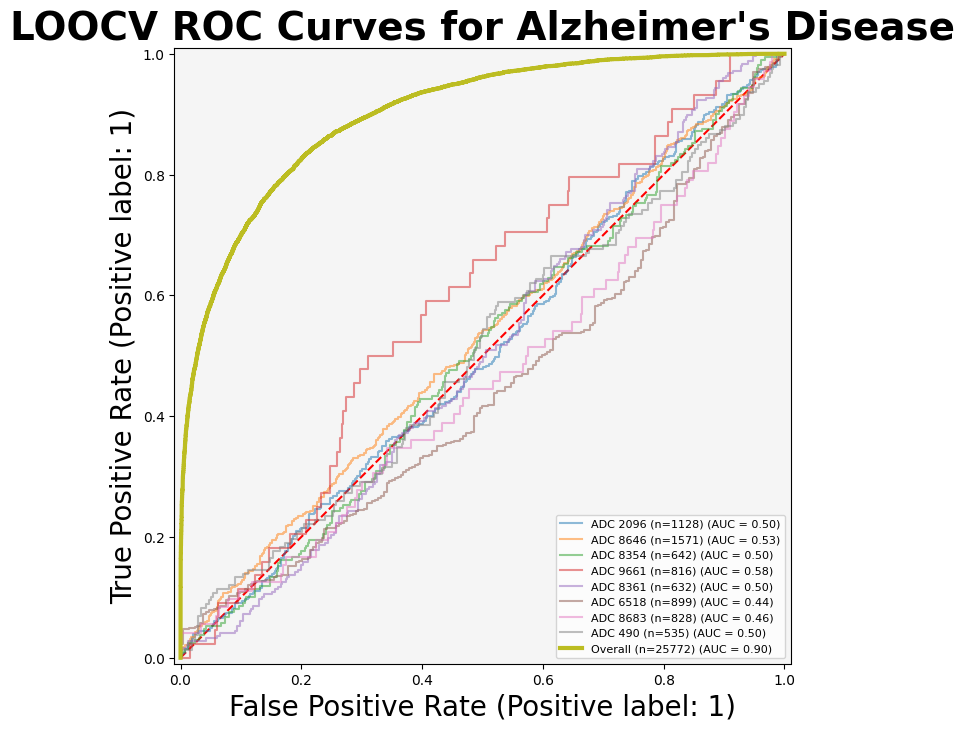

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:45:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Metrics for Alzheimer's Disease ---
Accuracy:    0.8259
Precision:   0.7956
Recall:      0.7098
Specificity: 0.8937
ROC-AUC:     0.8996
PR-AUC:      0.8593

*** Vascular Dementia LOOCV ROC ***


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:48:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:49:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:50:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:51:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:52:48] WARNING: /w

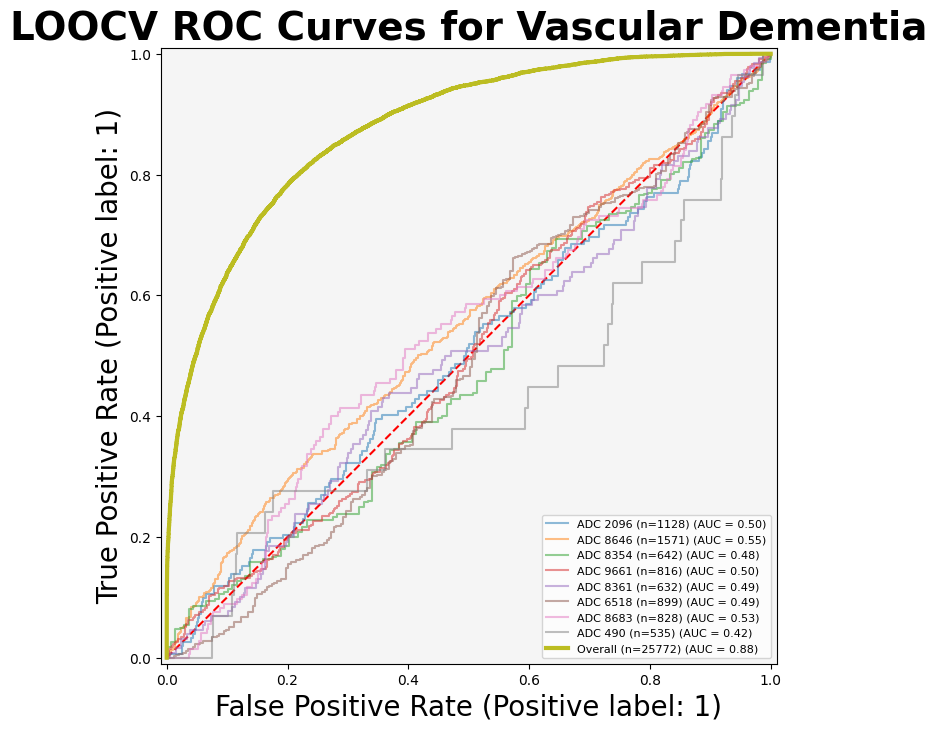

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:59:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Metrics for Vascular Dementia ---
Accuracy:    0.7866
Precision:   0.6667
Recall:      0.8056
Specificity: 0.7760
ROC-AUC:     0.8772
PR-AUC:      0.8187

*** Frontotemporal Lobar Degeneration LOOCV ROC ***


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:00:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:01:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:02:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:02:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:03:33] WARNING: /w

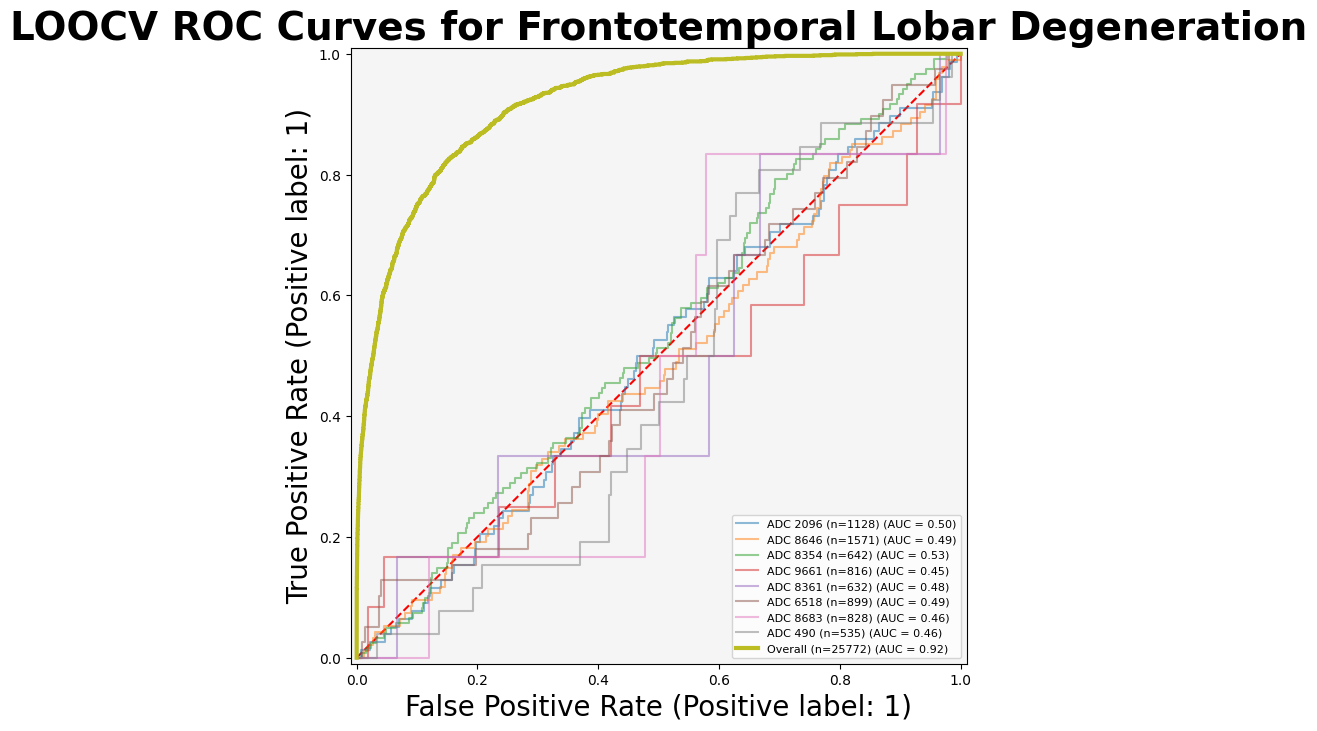

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:07:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Metrics for Frontotemporal Lobar Degeneration ---
Accuracy:    0.8886
Precision:   0.3481
Recall:      0.7519
Specificity: 0.8985
ROC-AUC:     0.9196
PR-AUC:      0.5937

*** Lewy Body Dementia LOOCV ROC ***


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:09:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:10:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:11:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:12:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:13:34] WARNING: /w

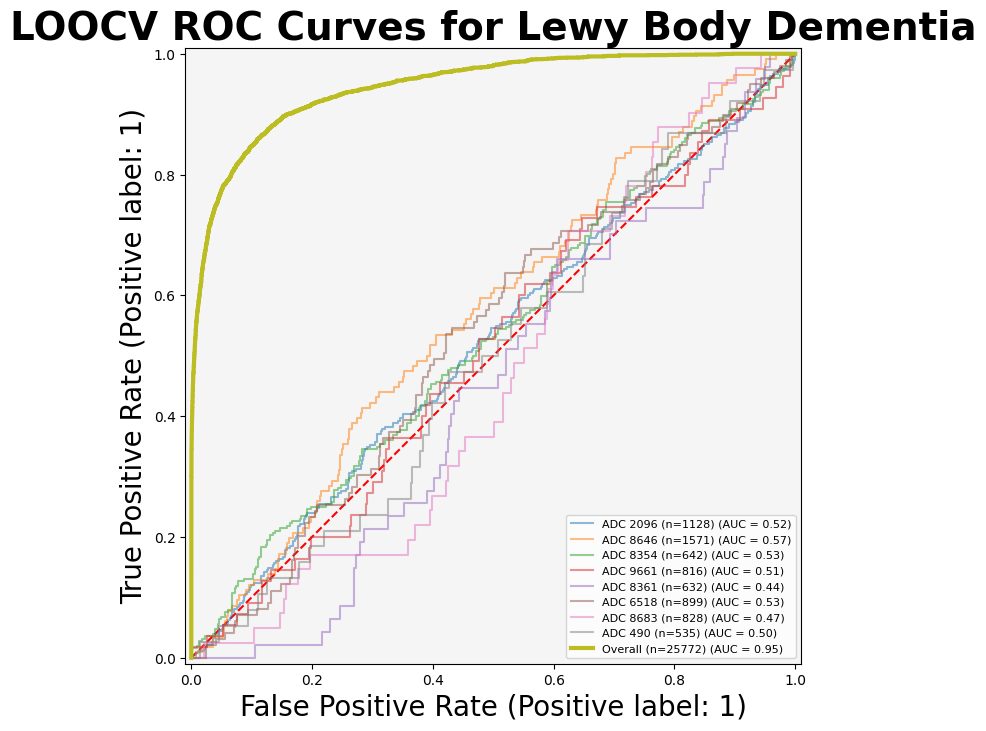

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:20:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Metrics for Lewy Body Dementia ---
Accuracy:    0.9347
Precision:   0.7255
Recall:      0.7445
Specificity: 0.9610
ROC-AUC:     0.9462
PR-AUC:      0.8205

*** Lewy Body Dementia LOOCV ROC ***


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:22:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:23:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:24:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:25:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:26:18] WARNING: /w

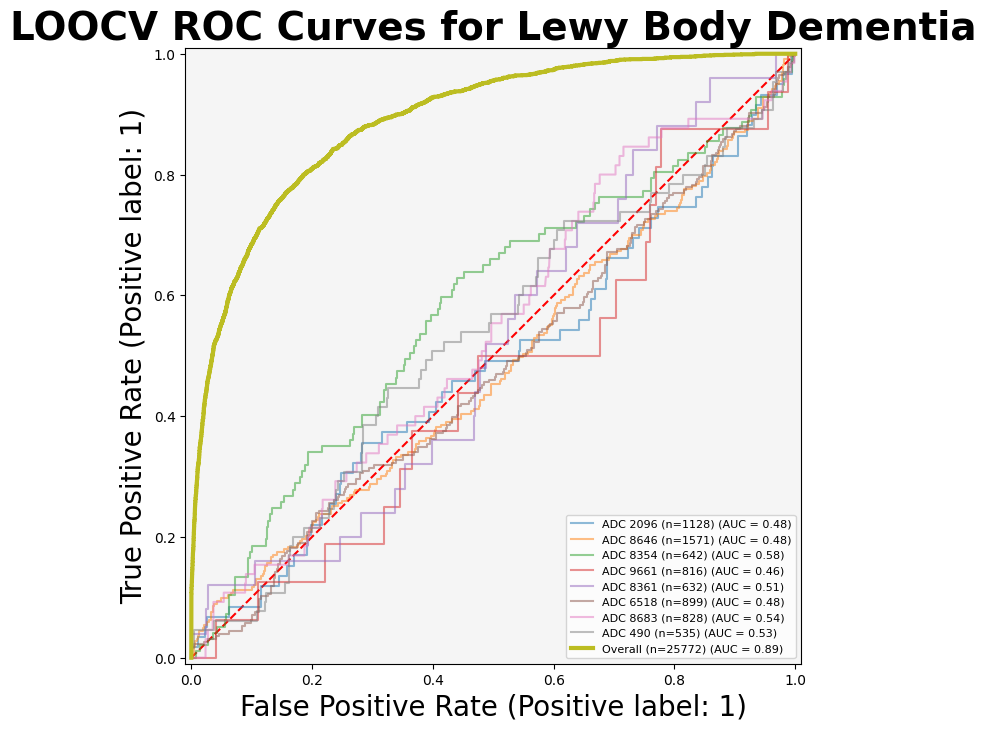

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:31:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Metrics for Lewy Body Dementia ---
Accuracy:    0.9099
Precision:   0.5045
Recall:      0.5701
Specificity: 0.9439
ROC-AUC:     0.8903
PR-AUC:      0.5770


In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress noisy warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.impute._base")
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn.impute._iterative")
warnings.filterwarnings("ignore", message=".*Ill-conditioned matrix.*")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, average_precision_score
)
import xgboost as xgb
from sklearn.metrics import RocCurveDisplay

# ----------------------------------------
# Configurable parameters
# ----------------------------------------
MIN_SAMPLES_PER_ADC = 200 #Jimmy had 200, 50-200 no change on ADC number

# Full disease names for display
disease_names = {
    'NPPAD': "Alzheimer's Disease",
    'NPCVASC': "Vascular Dementia",
    'NPPFTLD': "Frontotemporal Lobar Degeneration",
    'NPPLEWY': "Lewy Body Dementia",
    'NPCLEWY': "Lewy Body Dementia"
}

# ----------------------------------------
# 1. Data Preprocessing
# ----------------------------------------
print("Starting data preprocessing...")
pre_diagnosis_df = pre_diagnosis_df.copy()

target_columns = list(disease_names.keys())
features = pre_diagnosis_df.drop(columns=target_columns)
targets  = pre_diagnosis_df[target_columns]
print("Splitting features and targets complete.")

def clean_target_values(df):
    print("Cleaning target values (replacing -4 and filling missing values)...")
    return df.replace(-4, np.nan).ffill().bfill()

def define_binary_labels(df):
    print("Converting target values to binary labels...")
    return df.replace({1.0: 1, 2.0: 0, 0.0: 0})

targets = define_binary_labels(clean_target_values(targets))

naccadc_series = features['NACCADC']
print("Converting feature columns to numeric...")
features_numeric = features.drop(columns=['NACCADC']).apply(pd.to_numeric, errors='coerce')

# Drop columns with all NaNs
all_nan_cols = features_numeric.columns[features_numeric.isna().all()]
if len(all_nan_cols) > 0:
    print(f"Dropping {len(all_nan_cols)} all-missing features before imputation.")
    features_numeric = features_numeric.drop(columns=all_nan_cols)

# ----------------------------------------
# 2. Imputation
# ----------------------------------------
print("Performing efficient imputation using IterativeImputer with Ridge estimator...")
imputer = IterativeImputer(
    estimator=Ridge(alpha=1.0),
    random_state=42,
    max_iter=3,
    tol=1e-1,
    initial_strategy='mean',
    imputation_order='ascending',
    n_nearest_features=20,
    skip_complete=True
)
features_imputed_numeric = pd.DataFrame(
    imputer.fit_transform(features_numeric),
    columns=features_numeric.columns,
    index=features_numeric.index
)

# Recombine
features_imputed = features_imputed_numeric.copy()
features_imputed['NACCADC'] = naccadc_series.loc[features_imputed.index]
features_imputed = features_imputed.dropna()
targets = targets.loc[features_imputed.index]
print(f"Dataset dimensions after imputation: {features_imputed.shape}")

# ----------------------------------------
# 3. Train/Test Split
# ----------------------------------------
print("Creating random train/test split...")
train_idx, test_idx = train_test_split(features_imputed.index, test_size=0.2, random_state=42)
x_train = features_imputed.loc[train_idx]
x_test = features_imputed.loc[test_idx]
y_train = targets.loc[train_idx]
y_test = targets.loc[test_idx]
print(f"Train samples: {x_train.shape[0]}, Test samples: {x_test.shape[0]}")

feature_subset = [c for c in features_imputed.columns if c != 'NACCADC']

# ----------------------------------------
# 4. Best Hyperparameters (from BO)
# ----------------------------------------
best_params_dict = {
    'NPPAD':   {'colsample_bytree':0.2959, 'gamma':0.0665, 'learning_rate':0.0727,
                'max_depth':9, 'min_child_weight':2, 'n_estimators':273, 'scale_pos_weight':1.403},
    'NPCVASC': {'colsample_bytree':0.9028, 'gamma':0.3003, 'learning_rate':0.0593,
                'max_depth':9, 'min_child_weight':11,'n_estimators':174, 'scale_pos_weight':2.301},
    'NPPFTLD': {'colsample_bytree':0.7941, 'gamma':0.1587, 'learning_rate':0.1183,
                'max_depth':5, 'min_child_weight':11,'n_estimators':289, 'scale_pos_weight':16.588},
    'NPPLEWY': {'colsample_bytree':0.9596, 'gamma':0.2600, 'learning_rate':0.0646,
                'max_depth':9, 'min_child_weight':21,'n_estimators':282, 'scale_pos_weight':8.223},
    'NPCLEWY': {'colsample_bytree':0.5439, 'gamma':0.2913, 'learning_rate':0.0365,
                'max_depth':7, 'min_child_weight':21,'n_estimators':277, 'scale_pos_weight':6.969}
}

# ----------------------------------------
# 5. Build ADC list for LOOCV
# ----------------------------------------
OYS_ADCs = []
for adc in x_test['NACCADC'].unique():
    mask = x_test['NACCADC'] == adc
    if mask.sum() < MIN_SAMPLES_PER_ADC:
        continue
    yv = y_test[mask]
    if yv.nunique().min() < 2:
        continue
    OYS_ADCs.append(adc)
print(f"Using {len(OYS_ADCs)} ADCs for LOOCV")

# ----------------------------------------
# 6. LOOCV Plot Function
# ----------------------------------------
def loocv(params, x_train, y_train, x_test, y_test, adcs, disease_label):
    plt.figure(figsize=(10,8))
    ax = plt.gca()
    ax.set_facecolor((0.96,0.96,0.96))
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    plt.title(f"LOOCV ROC Curves for {disease_label}", fontdict={'weight':'bold','size':28})
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel('False Positive Rate', fontdict={'size':20})
    plt.ylabel('True Positive Rate', fontdict={'size':20})
    plt.xlim(-0.01,1.01); plt.ylim(-0.01,1.01)

    loocv_params = params.copy()
    loocv_params['n_estimators'] = 100
    loocv_params.update({'random_state':42, 'use_label_encoder':False, 'objective':'binary:logistic'})

    for adc in adcs:
        xt = x_train[x_train['NACCADC'] != adc][feature_subset]
        yt = y_train[x_train['NACCADC'] != adc]
        xv = x_test[x_test['NACCADC'] == adc][feature_subset]
        yv = y_test[x_test['NACCADC'] == adc]

        clf = xgb.XGBClassifier(n_jobs=-1, **loocv_params)
        clf.fit(xt, yt)
        RocCurveDisplay.from_estimator(
            clf, xv, yv,
            name=f'ADC {adc} (n={len(xv)})',
            alpha=0.5, ax=ax
        )

    # Final overall model
    clf = xgb.XGBClassifier(n_jobs=-1, **params)
    clf.fit(x_train[feature_subset], y_train)
    RocCurveDisplay.from_estimator(
        clf, x_test[feature_subset], y_test,
        name=f'Overall (n={len(x_test)})',
        lw=3, ax=ax
    )

    plt.legend(loc='lower right', prop={'size':8})
    plt.show()

# ----------------------------------------
# 7. Run LOOCV + Print Final Metrics
# ----------------------------------------
def print_metrics(model, X, y, disease_label):
    print(f"\n--- Metrics for {disease_label} ---")
    preds = model.predict(X)
    probs = model.predict_proba(X)[:,1]
    print(f"Accuracy:    {accuracy_score(y,preds):.4f}")
    print(f"Precision:   {precision_score(y,preds):.4f}")
    print(f"Recall:      {recall_score(y,preds):.4f}")
    print(f"Specificity: {recall_score(y,preds,pos_label=0):.4f}")
    print(f"ROC-AUC:     {roc_auc_score(y,probs):.4f}")
    print(f"PR-AUC:      {average_precision_score(y,probs):.4f}")

for col in target_columns:
    name = disease_names[col]
    print(f"\n*** {name} LOOCV ROC ***")
    base_params = best_params_dict[col].copy()
    base_params.update({'random_state': 42, 'use_label_encoder': False, 'objective': 'binary:logistic'})

    loocv(
        params=base_params,
        x_train=x_train, y_train=y_train[col],
        x_test=x_test, y_test=y_test[col],
        adcs=OYS_ADCs,
        disease_label=name
    )

    final_model = xgb.XGBClassifier(n_jobs=-1, **base_params)
    final_model.fit(x_train[feature_subset], y_train[col])
    print_metrics(final_model, x_test[feature_subset], y_test[col], name)


## **ROC, Precision-Recall CURVES**

Plotting ROC and Precision–Recall Curves for Test Set:


*** Plotting curves for target: NPPAD (Alzheimer's Disease) ***


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:33:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


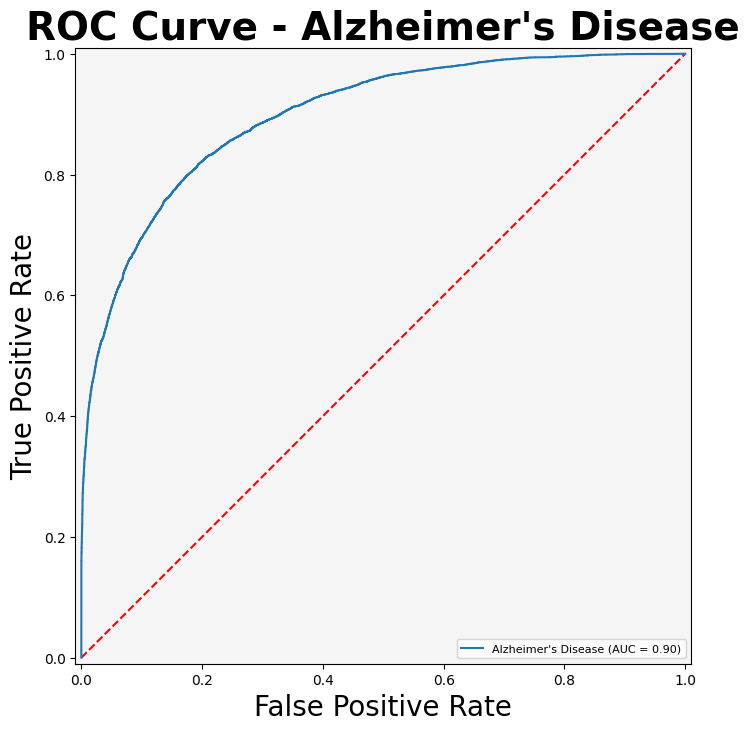

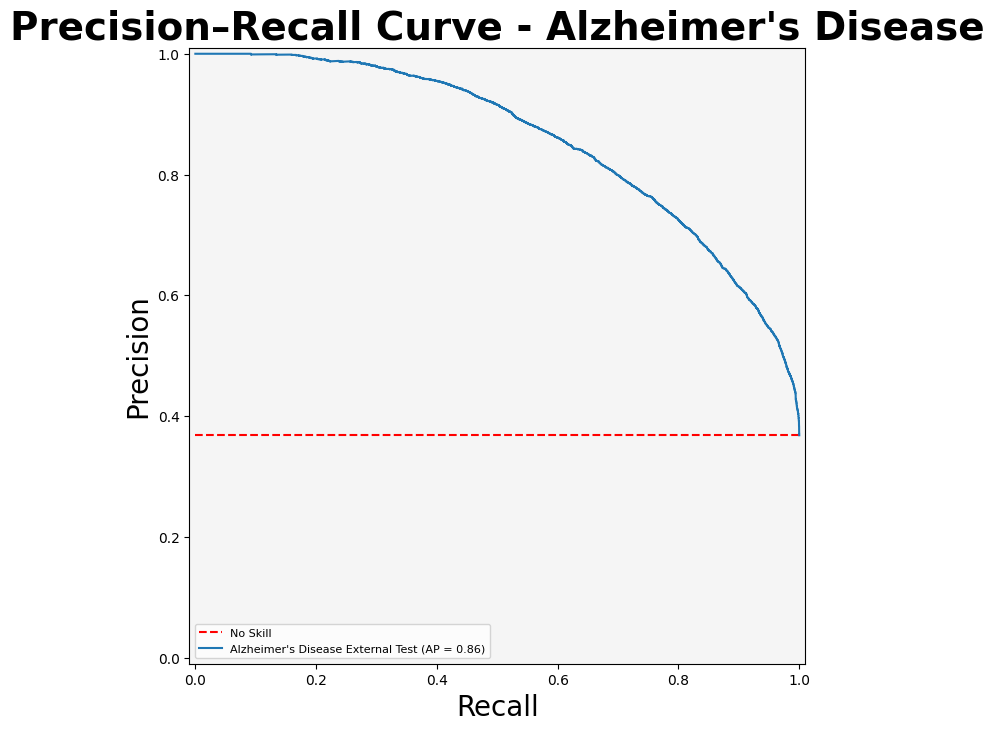


*** Plotting curves for target: NPCVASC (Vascular Dementia) ***


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:36:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


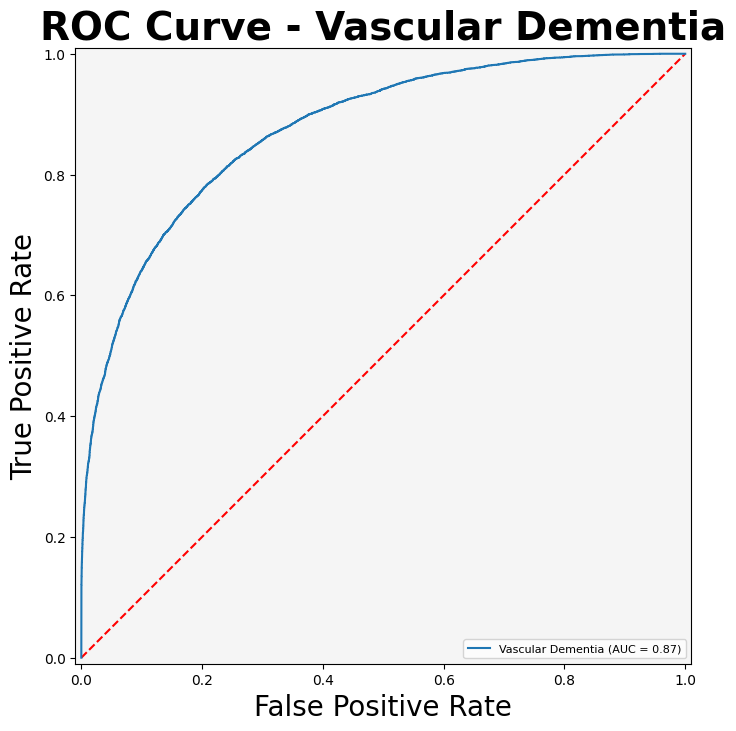

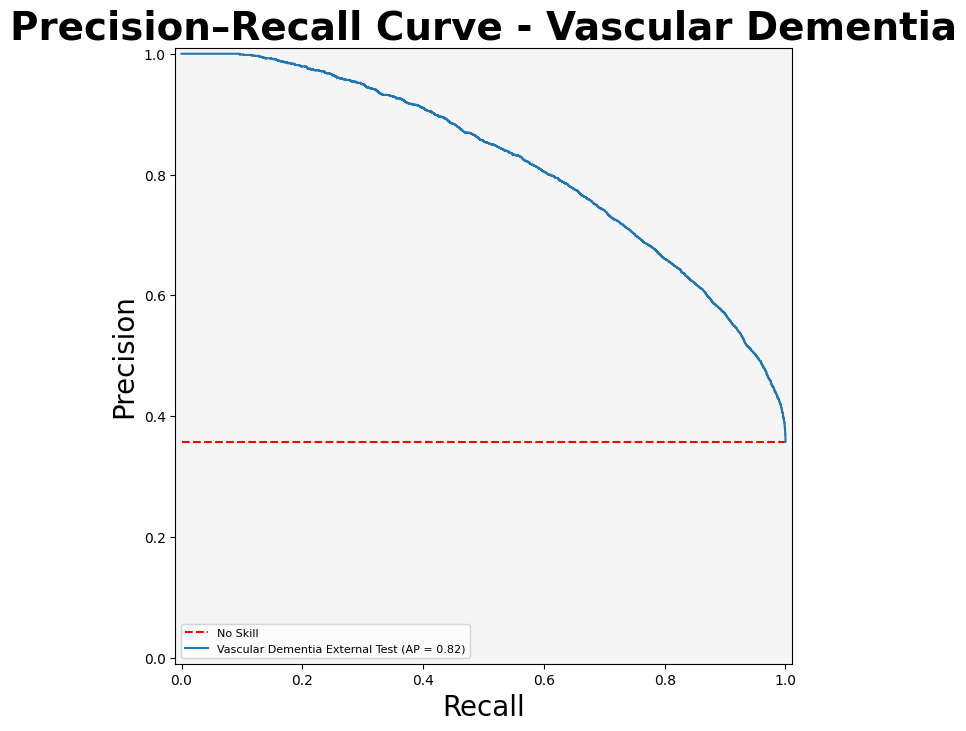


*** Plotting curves for target: NPPFTLD (Frontotemporal Lobar Degeneration) ***


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:37:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


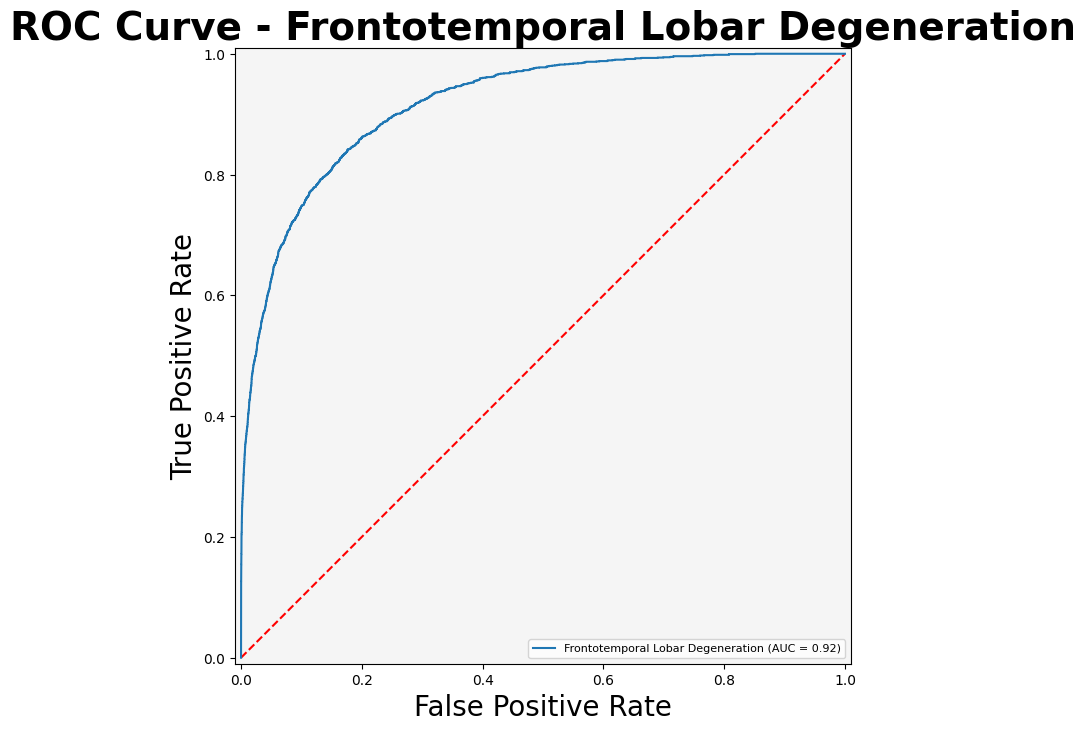

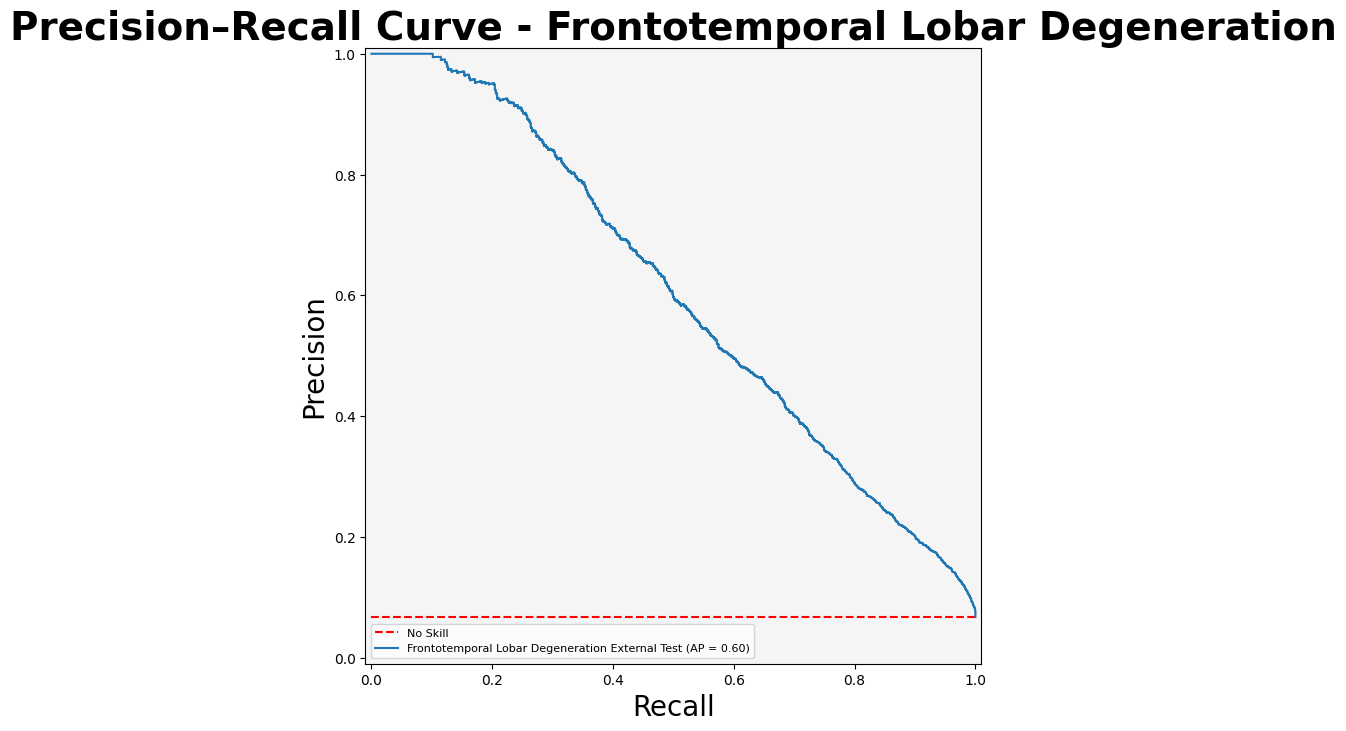


*** Plotting curves for target: NPPLEWY (Lewy Body Dementia) ***


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:39:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


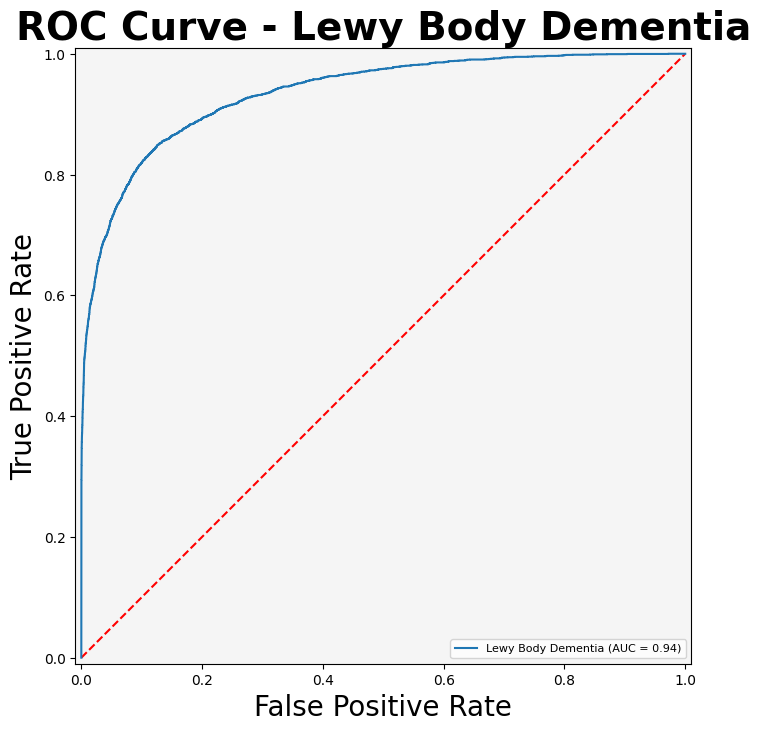

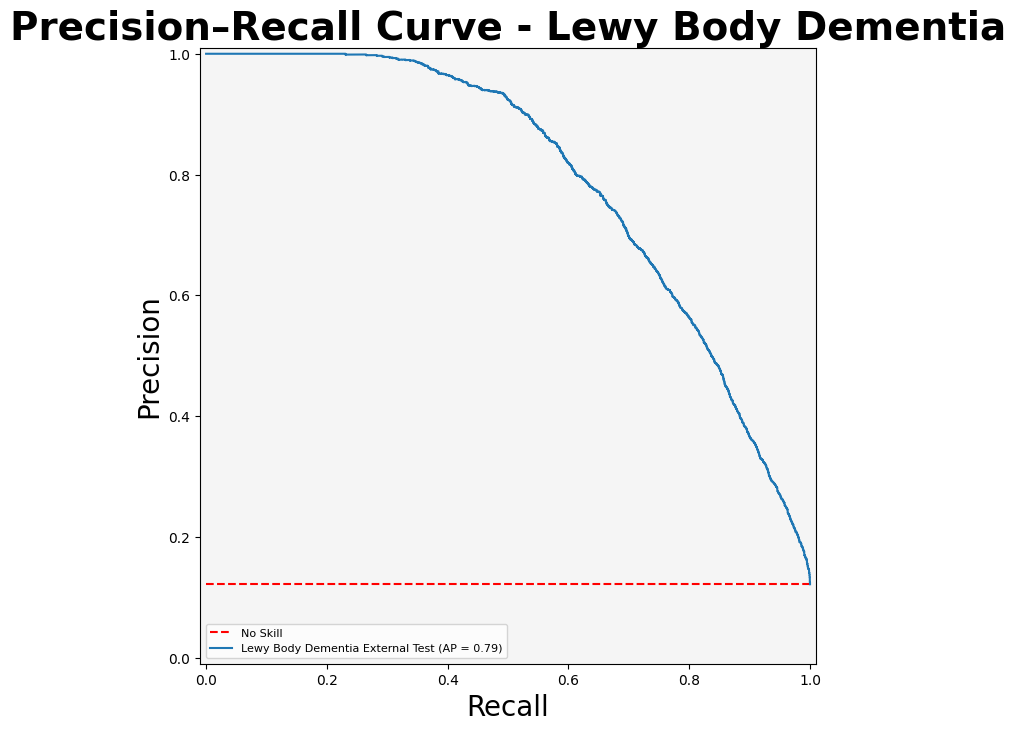


*** Plotting curves for target: NPCLEWY (Lewy Body Dementia) ***


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:41:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


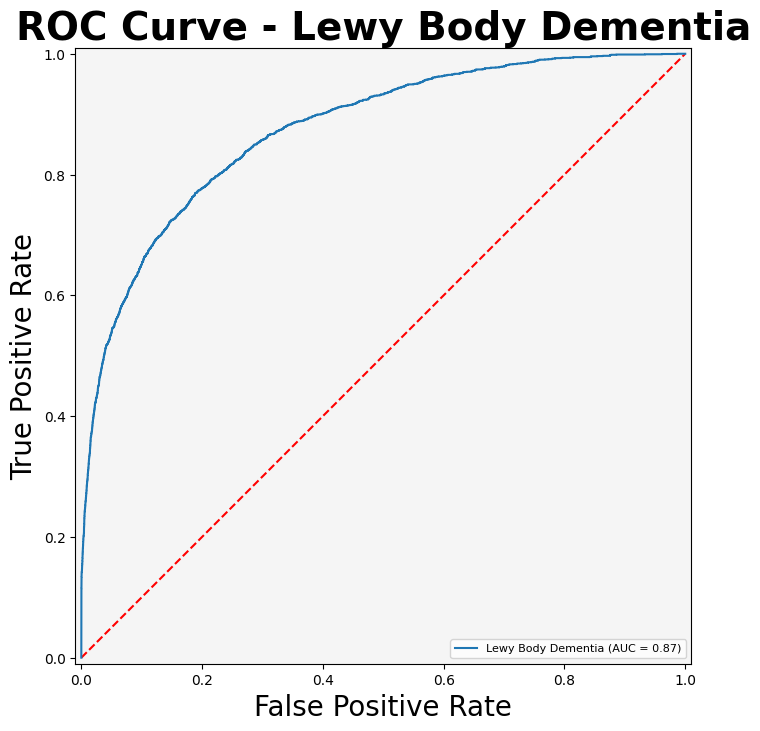

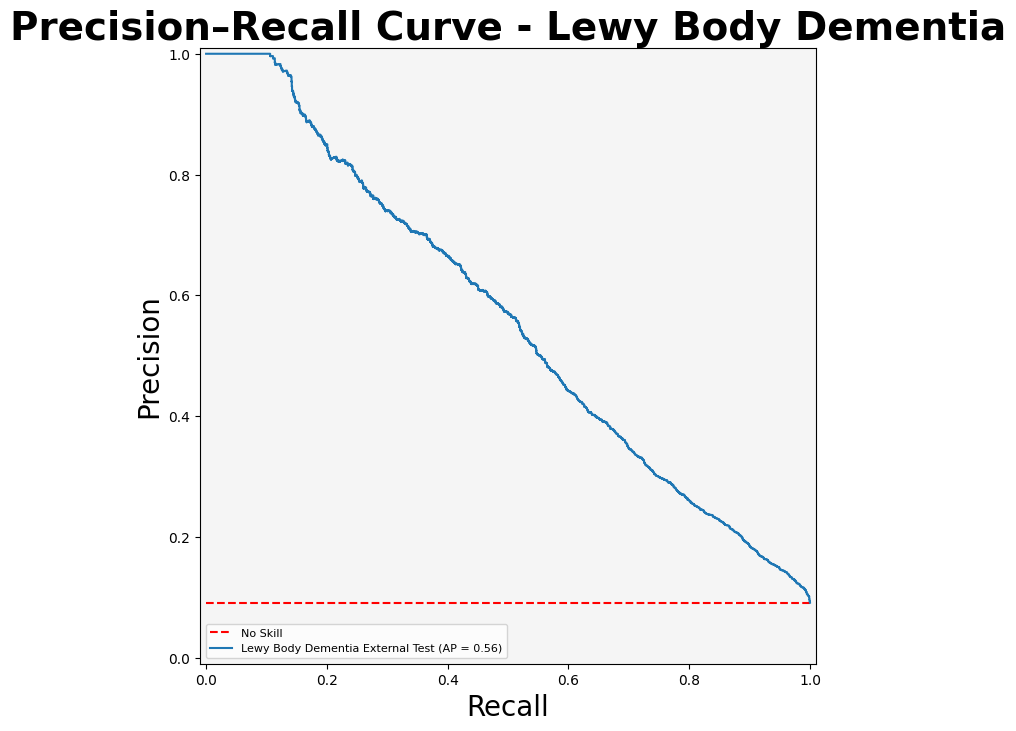


Plotting Combined ROC Curve for Test Set:



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:43:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:46:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:47:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:49:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:51:28] WARNING: /w

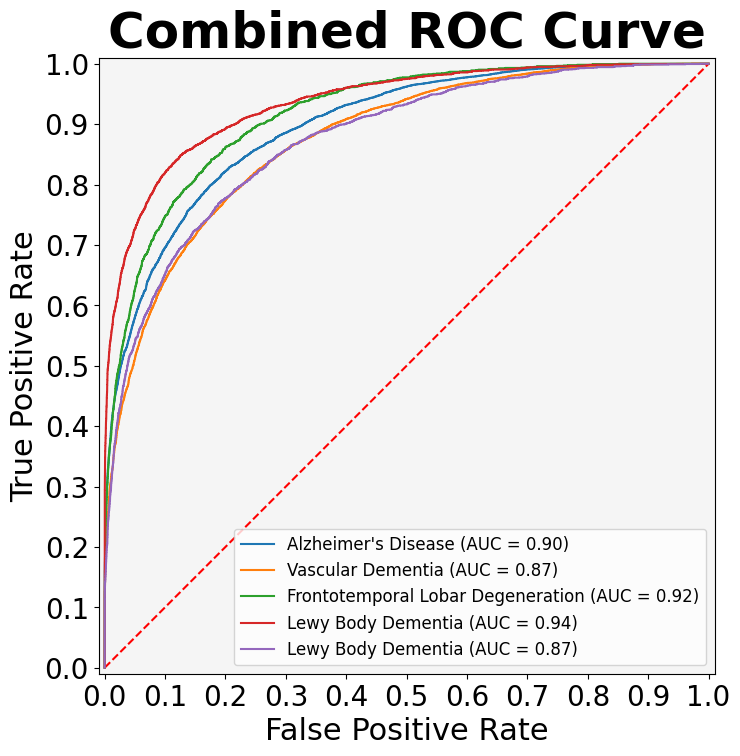

In [ ]:
# --------------------------
# 8. Plot ROC and Precision–Recall Curves on Test Set
# --------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import xgboost as xgb

print("Plotting ROC and Precision–Recall Curves for Test Set:\n")

for col in target_columns:
    print(f"\n*** Plotting curves for target: {col} ({disease_names[col]}) ***")

    # Prepare final model with best hyperparameters
    params = best_params_dict[col].copy()
    params.update({
        'random_state': 42,
        'use_label_encoder': False,
        'objective': 'binary:logistic'
    })
    model = xgb.XGBClassifier(n_jobs=-1, **params)
    model.fit(x_train[feature_subset], y_train[col])

    # ---- ROC Curve ----
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    ax.set_facecolor((0.96, 0.96, 0.96))
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    plt.plot([0, 1], [0, 1], 'r--')
    RocCurveDisplay.from_estimator(
        model,
        x_test[feature_subset],
        y_test[col],
        name=f"{disease_names[col]}",  # removed (n=...) from label
        ax=ax
    )
    plt.title(f"ROC Curve - {disease_names[col]}", fontdict={'weight':'bold','size':28})
    plt.xlabel('False Positive Rate', fontdict={'size':20})
    plt.ylabel('True Positive Rate', fontdict={'size':20})
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.legend(loc='lower right', prop={'size':8})
    plt.show()

    # ---- Precision–Recall Curve ----
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    ax.set_facecolor((0.96, 0.96, 0.96))
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    no_skill = y_test[col].mean()
    plt.plot([0, 1], [no_skill, no_skill], 'r--', label='No Skill')
    PrecisionRecallDisplay.from_estimator(
        model,
        x_test[feature_subset],
        y_test[col],
        name=f"{disease_names[col]} External Test",
        ax=ax
    )
    plt.title(f"Precision–Recall Curve - {disease_names[col]}", fontdict={'weight':'bold','size':28})
    plt.xlabel('Recall', fontdict={'size':20})
    plt.ylabel('Precision', fontdict={'size':20})
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.legend(loc='lower left', prop={'size':8})
    plt.show()

# --------------------------
# Combined ROC Curve for All Targets
# --------------------------
print("\nPlotting Combined ROC Curve for Test Set:\n")

plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.set_facecolor((0.96, 0.96, 0.96))
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
plt.plot([0, 1], [0, 1], 'r--')

for col in target_columns:
    params = best_params_dict[col].copy()
    params.update({
        'random_state': 42,
        'use_label_encoder': False,
        'objective': 'binary:logistic'
    })
    model = xgb.XGBClassifier(n_jobs=-1, **params)
    model.fit(x_train[feature_subset], y_train[col])
    RocCurveDisplay.from_estimator(
        model,
        x_test[feature_subset],
        y_test[col],
        name=disease_names[col],
        ax=ax
    )

plt.title("Combined ROC Curve", fontdict={'weight':'bold','size':36})
plt.xlabel('False Positive Rate', fontdict={'weight':'normal','size':22})
plt.ylabel('True Positive Rate', fontdict={'weight':'normal','size':22})
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=20)
plt.yticks(np.arange(0.0, 1.1, 0.1), fontsize=20)
plt.legend(loc='lower right', fontsize='large')
plt.show()


## **SHAP FEATURE ANALYSIS**

In [ ]:
# ----------------------------------------
# SHAP: Compute, Normalize, and Filter Top Features
# ----------------------------------------
import shap

print("Computing SHAP values and preparing feature matrix...")

shap_values_dict = {}
models_dict = {}
mean_shap_vals = pd.DataFrame(index=feature_subset)

for col in target_columns:
    name = disease_names[col]
    print(f"Training model and computing SHAP for {name}...")

    params = best_params_dict[col].copy()
    params.update({'random_state': 42, 'use_label_encoder': False, 'objective': 'binary:logistic'})

    model = xgb.XGBClassifier(n_jobs=-1, **params)
    model.fit(x_train[feature_subset], y_train[col])

    models_dict[col] = model

    explainer = shap.Explainer(model)
    shap_values = explainer(x_train[feature_subset])
    shap_values_dict[col] = shap_values

    # Mean absolute SHAP and normalization
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    percent_contrib = 100 * mean_abs_shap / mean_abs_shap.sum()
    mean_shap_vals[col] = percent_contrib

# Filter and cap for visualization
filtered_features = mean_shap_vals[mean_shap_vals.max(axis=1) > 2.5]
capped_shap_vals = filtered_features.clip(upper=10)

print(f"Selected {capped_shap_vals.shape[0]} features with >2.5% SHAP in at least one subtype.")


Computing SHAP values and preparing feature matrix...
Training model and computing SHAP for Alzheimer's Disease...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:24:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training model and computing SHAP for Vascular Dementia...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:39:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training model and computing SHAP for Frontotemporal Lobar Degeneration...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:47:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training model and computing SHAP for Lewy Body Dementia...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:50:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training model and computing SHAP for Lewy Body Dementia...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:59:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Selected 5 features with >2.5% SHAP in at least one subtype.



>>> SHAP Beeswarm Plot for Alzheimer's Disease


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:08:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


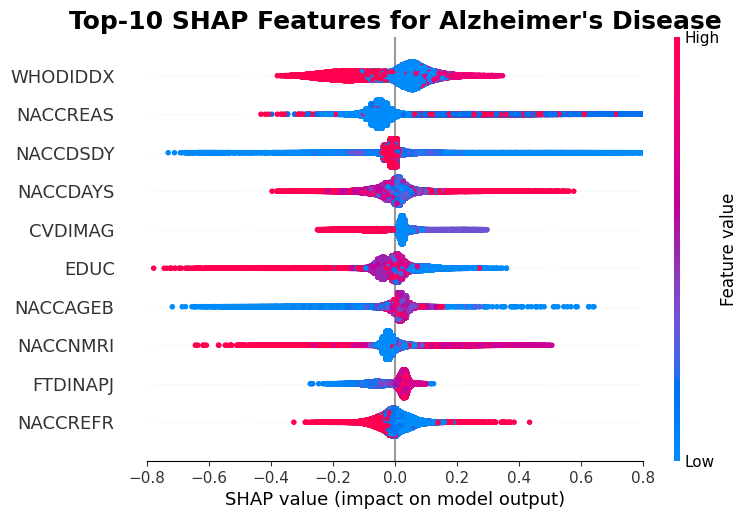


>>> SHAP Beeswarm Plot for Vascular Dementia


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:23:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


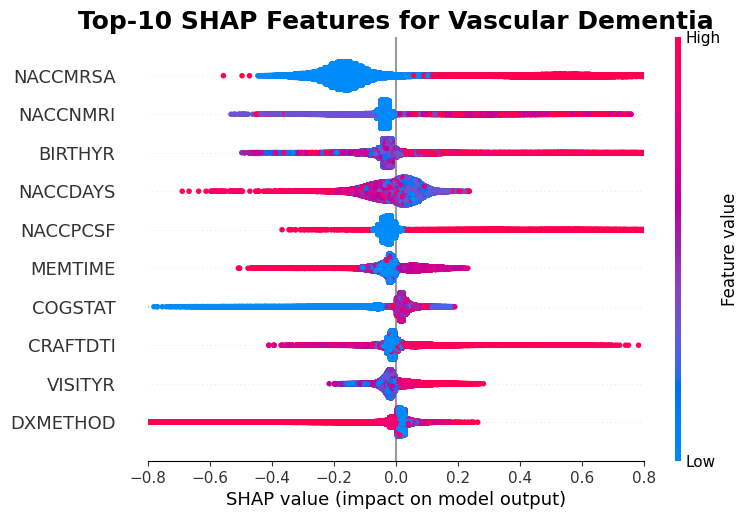


>>> SHAP Beeswarm Plot for Frontotemporal Lobar Degeneration


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:31:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


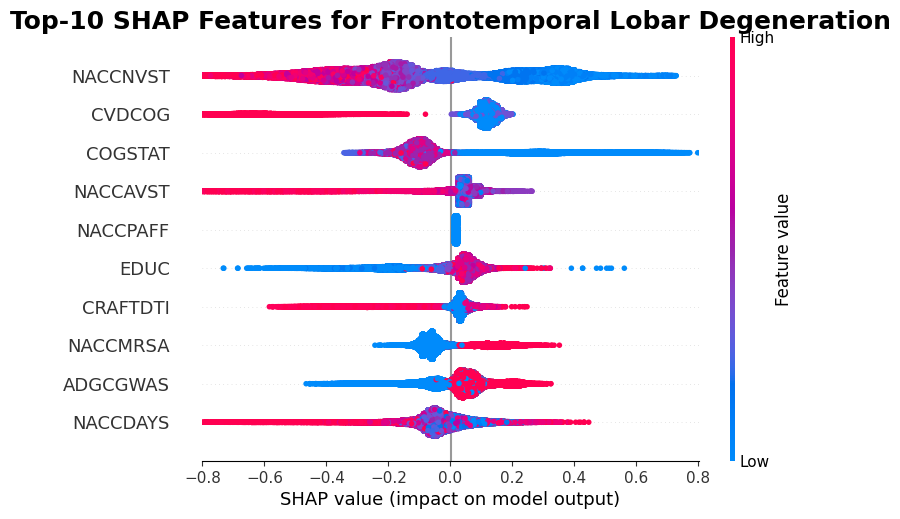


>>> SHAP Beeswarm Plot for Lewy Body Dementia


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:34:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


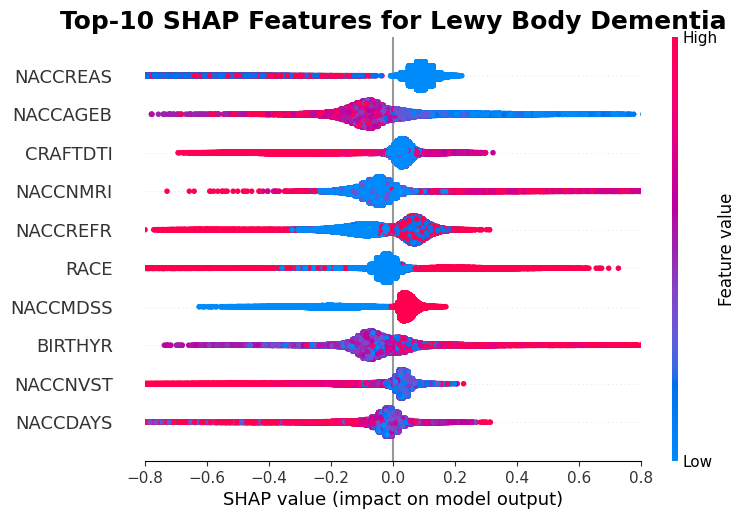


>>> SHAP Beeswarm Plot for Lewy Body Dementia


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:43:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


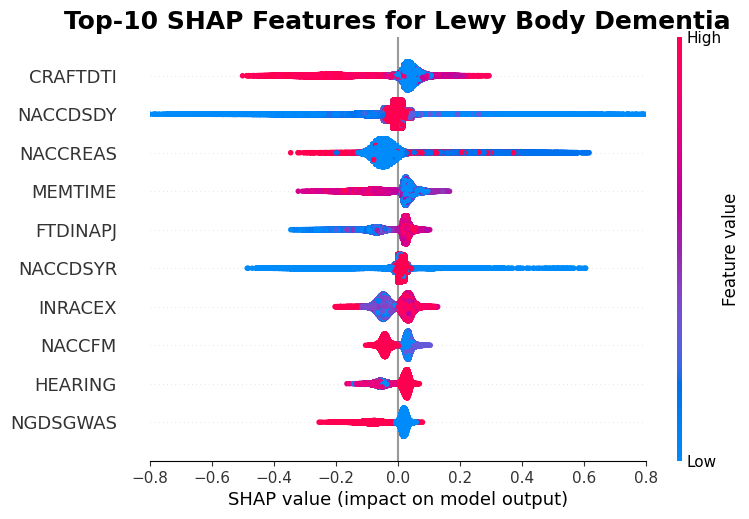

In [ ]:
# ----------------------------------------
# SHAP Beeswarm Plots (Top‑10 Features) per Dementia Type
# ----------------------------------------
import shap
import numpy as np
import matplotlib.pyplot as plt

def filter_top_features(shap_exp, num_top):
    """
    Keep only the top `num_top` features by mean absolute SHAP value.
    """
    mean_abs = np.abs(shap_exp.values).mean(axis=0)
    top_idx = np.argsort(mean_abs)[-num_top:]
    # slice out only those columns
    return shap.Explanation(
        values=shap_exp.values[:, top_idx],
        base_values=shap_exp.base_values,
        data=shap_exp.data[:, top_idx],
        feature_names=[shap_exp.feature_names[i] for i in top_idx]
    )

def shapBeeswarmPlot(model, data, num_features=10, title=""):
    """
    Compute SHAP values on `data`, filter to top `num_features`, and draw beeswarm.
    """
    explainer = shap.TreeExplainer(model)
    shap_exp = explainer(data)
    shap_exp = filter_top_features(shap_exp, num_features)

    plt.figure(figsize=(10,8))
    plt.title(title, fontdict={'weight':'bold', 'size':18})
    shap.plots.beeswarm(shap_exp, show=False)
    plt.xlim(-0.8, 0.8)
    plt.xticks(np.arange(-0.8, 0.81, 0.2))
    plt.show()


# Loop over your main dementia types
main_diseases = ['NPPAD', 'NPCVASC', 'NPPFTLD', 'NPPLEWY', 'NPCLEWY']

for col in main_diseases:
    name = disease_names[col]
    print(f"\n>>> SHAP Beeswarm Plot for {name}")

    # Retrain the subtype‐specific model
    params = best_params_dict[col].copy()
    params.update({
        'random_state': 42,
        'use_label_encoder': False,
        'objective': 'binary:logistic'
    })
    model = xgb.XGBClassifier(n_jobs=-1, **params)
    model.fit(x_train[feature_subset], y_train[col])

    # Draw the beeswarm of top 10
    shapBeeswarmPlot(
        model,
        x_train[feature_subset],
        num_features=10,
        title=f"Top‑10 SHAP Features for {name}"
    )


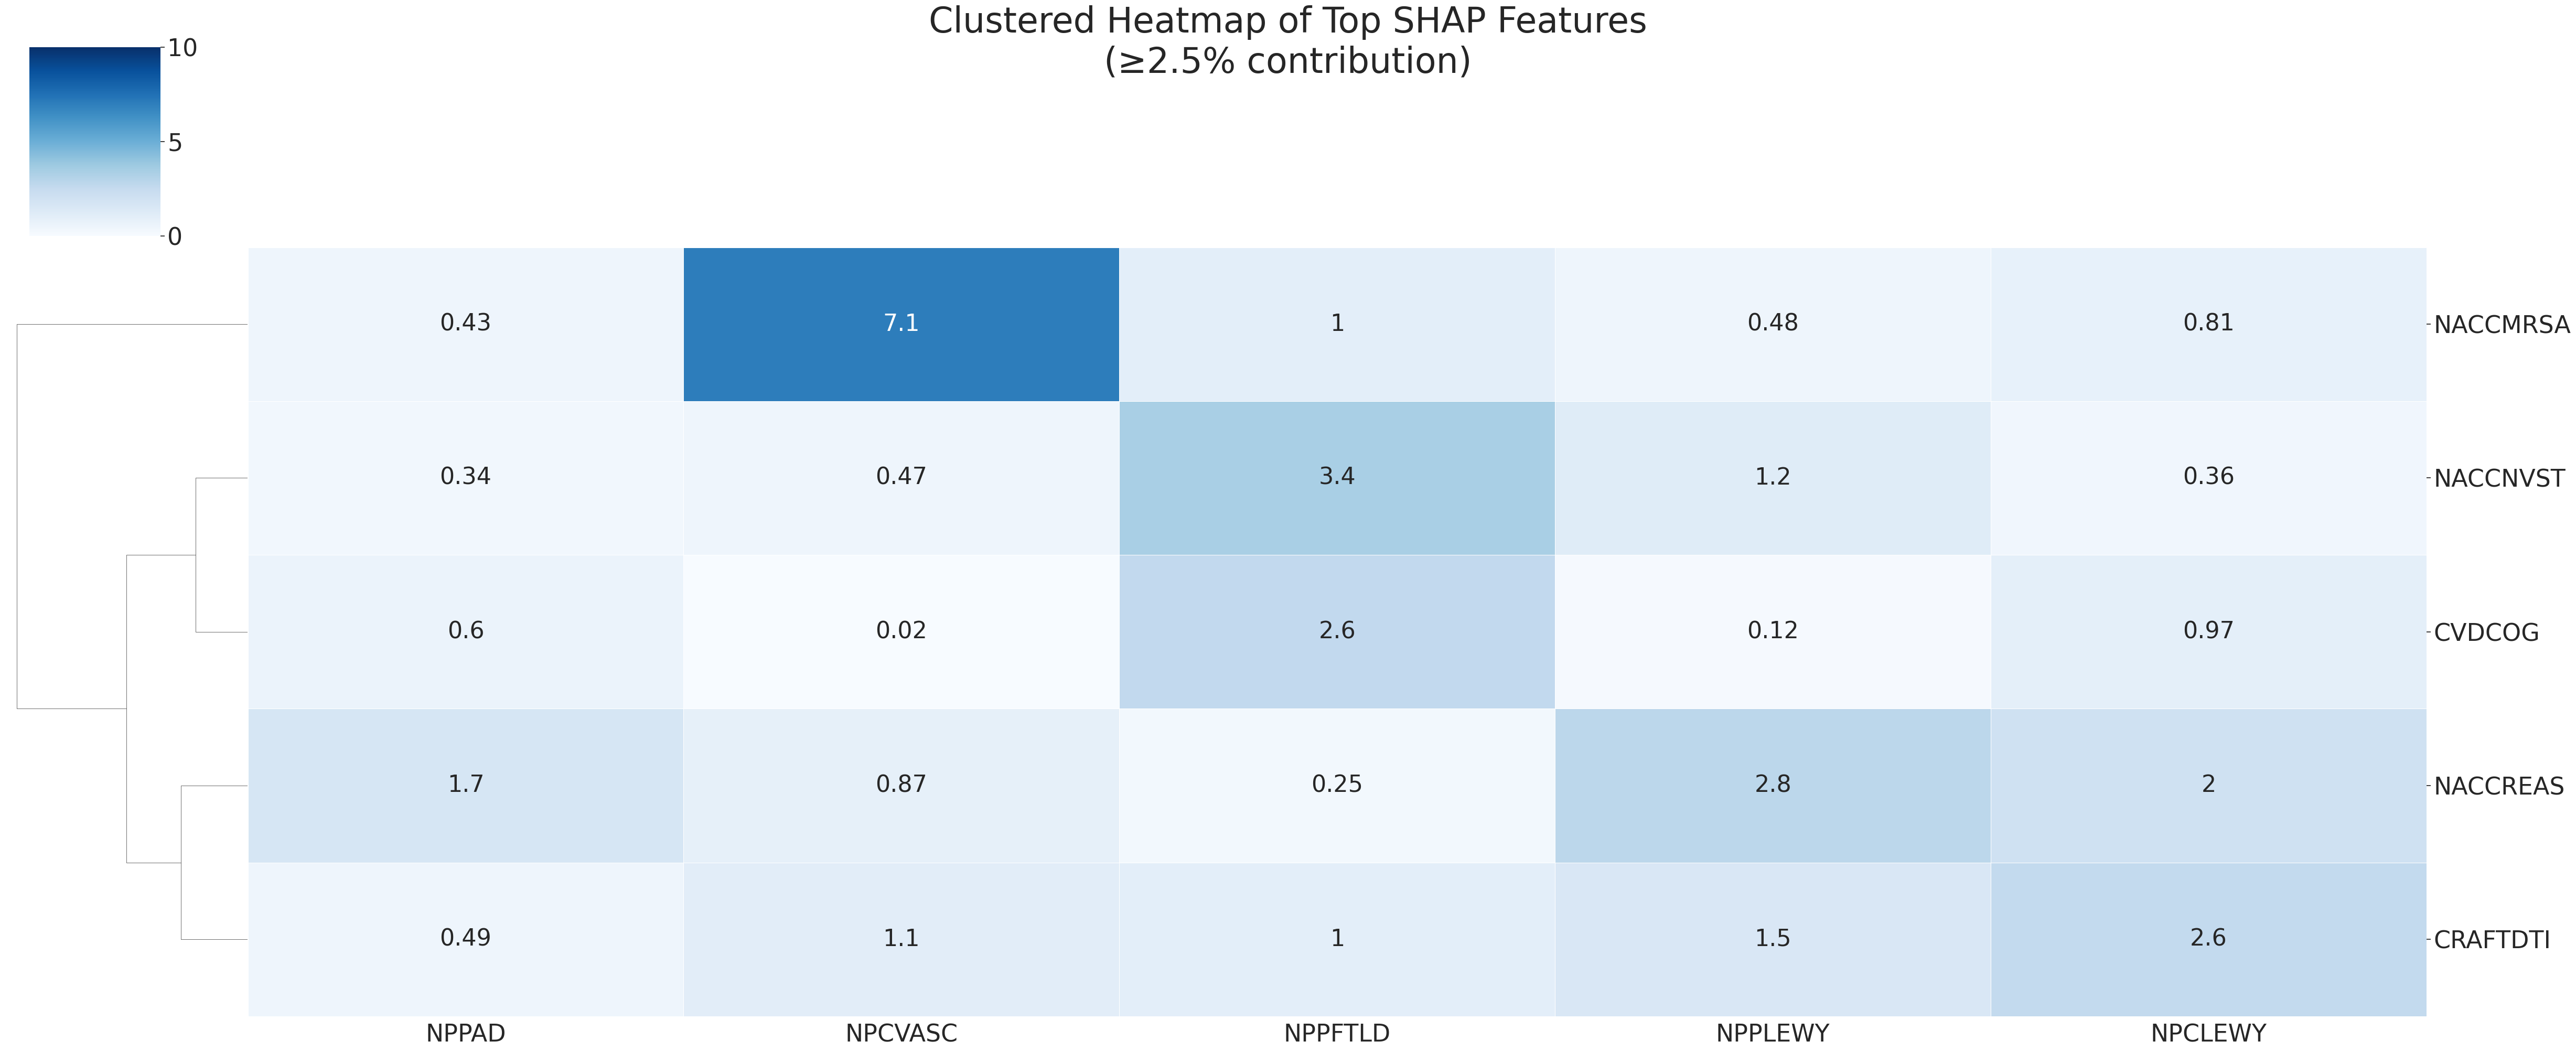

In [ ]:
# ----------------------------------------
# SHAP: Styled Clustered Heatmap of Top Features Across Dementia Types
# (only features with ≥2.5% contribution in any subtype)
# ----------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filter features with ≥2.5% SHAP in at least one subtype
top_features = mean_shap_vals.loc[mean_shap_vals.max(axis=1) >= 2.5]

# 2. Cap at 10% and round for neat annotation
clustermap_data = top_features.clip(upper=10).round(2)

# 3. Styling
sns.set(font_scale=3)

# 4. Plot annotated clustermap
shap_clust = sns.clustermap(
    clustermap_data,
    figsize=(50, 20),
    annot=True,
    cmap='Blues',
    annot_kws={"size": 32},
    vmin=0,
    vmax=10,
    dendrogram_ratio=(.1, .2),
    linewidths=0.5,
    col_cluster=False  # keep dementia types in original order
)

# 5. Title and display
plt.suptitle(
    "Clustered Heatmap of Top SHAP Features\n(≥2.5% contribution)",
    fontsize=48,
    y=1.02
)
plt.show()


## **Correlation Matrix**

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:01:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


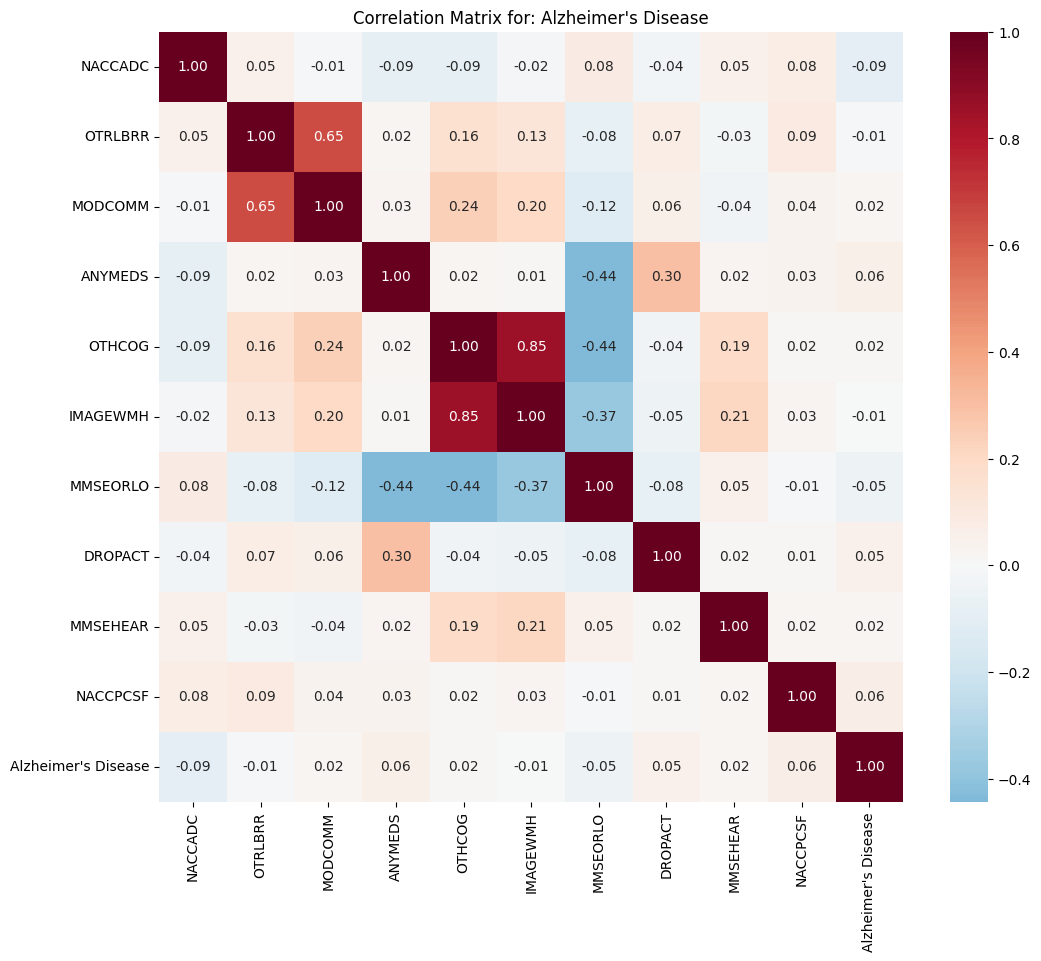

Top 10 features for Alzheimer's Disease: ['NACCADC', 'OTRLBRR', 'MODCOMM', 'ANYMEDS', 'OTHCOG', 'IMAGEWMH', 'MMSEORLO', 'DROPACT', 'MMSEHEAR', 'NACCPCSF']


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:03:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


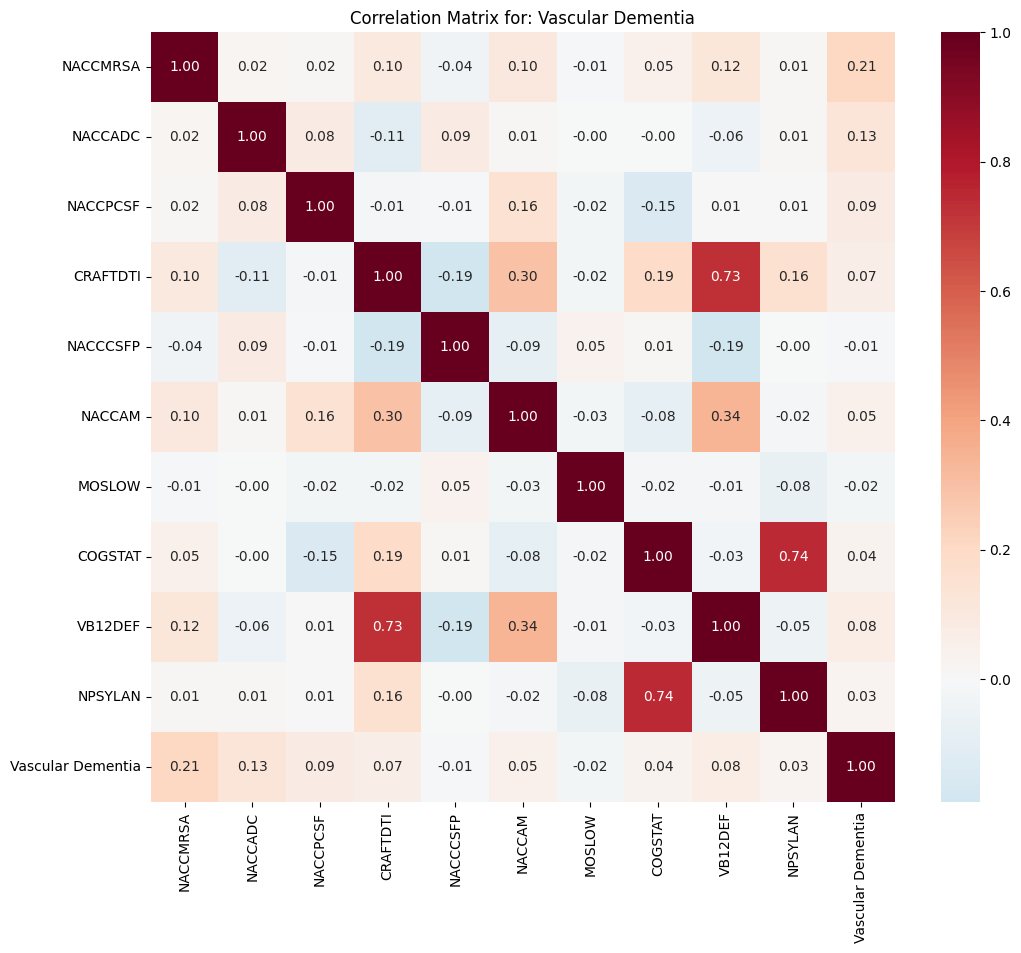

Top 10 features for Vascular Dementia: ['NACCMRSA', 'NACCADC', 'NACCPCSF', 'CRAFTDTI', 'NACCCSFP', 'NACCAM', 'MOSLOW', 'COGSTAT', 'VB12DEF', 'NPSYLAN']


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:05:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


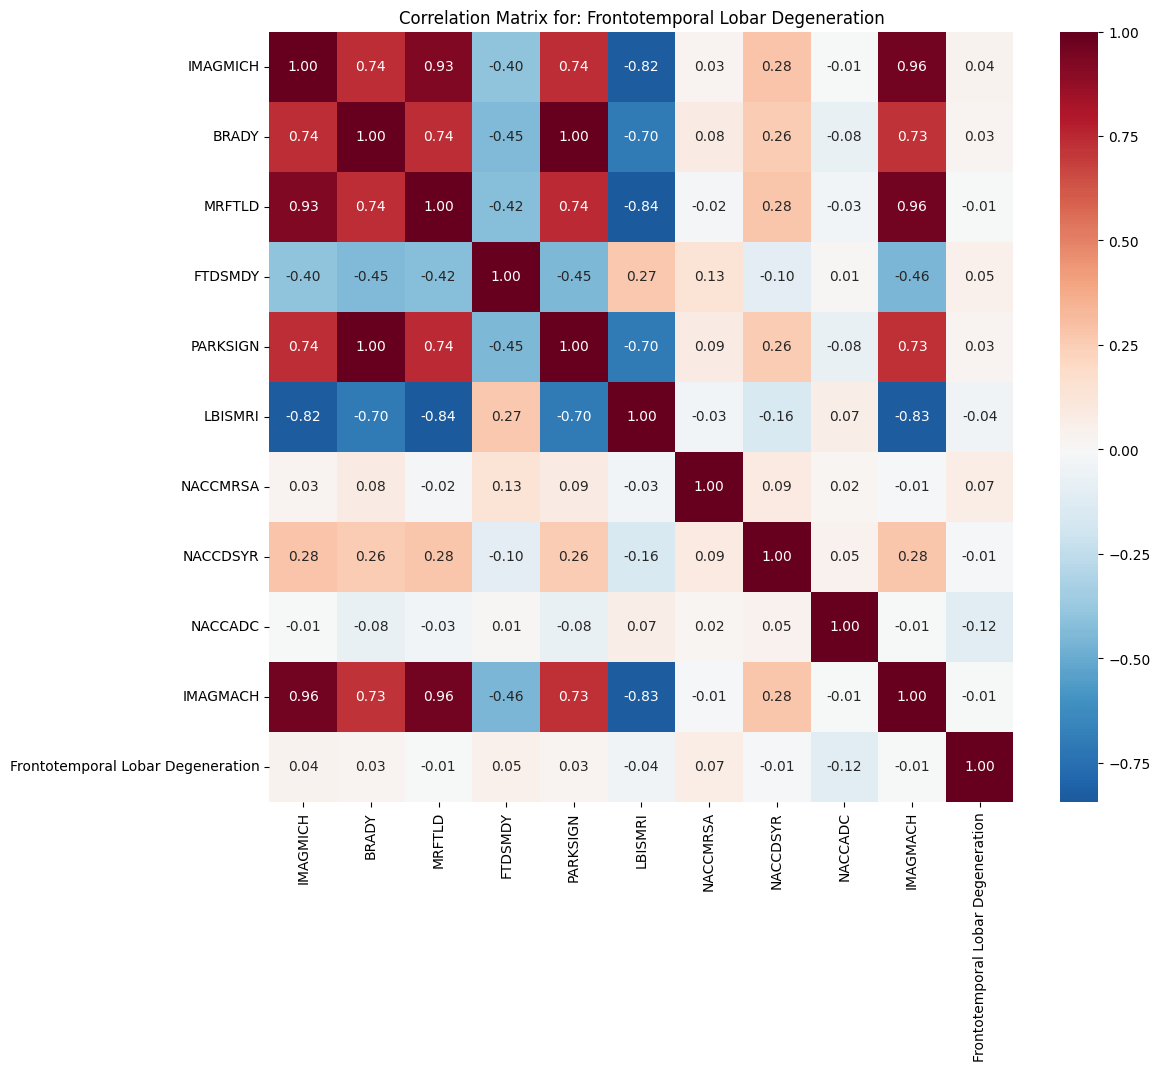

Top 10 features for Frontotemporal Lobar Degeneration: ['IMAGMICH', 'BRADY', 'MRFTLD', 'FTDSMDY', 'PARKSIGN', 'LBISMRI', 'NACCMRSA', 'NACCDSYR', 'NACCADC', 'IMAGMACH']


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:06:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


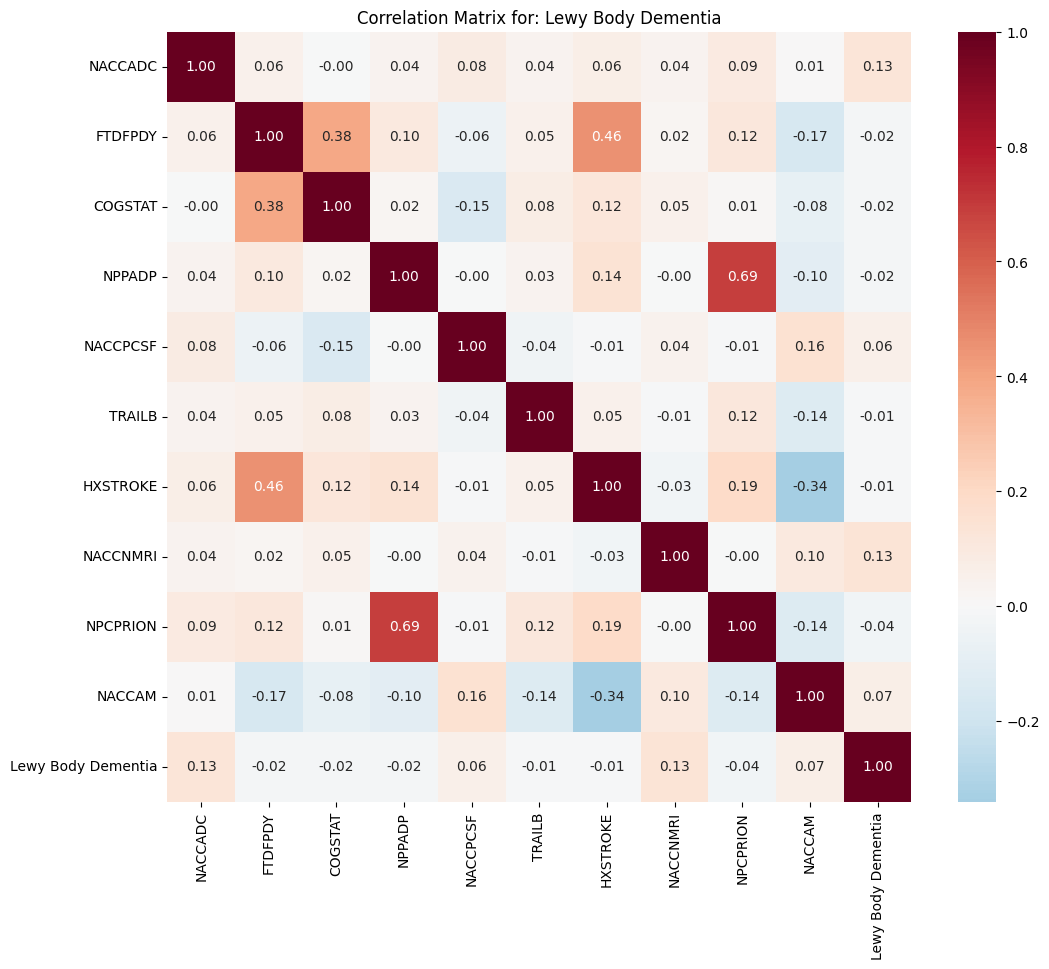

Top 10 features for Lewy Body Dementia: ['NACCADC', 'FTDFPDY', 'COGSTAT', 'NPPADP', 'NACCPCSF', 'TRAILB', 'HXSTROKE', 'NACCNMRI', 'NPCPRION', 'NACCAM']


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:09:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


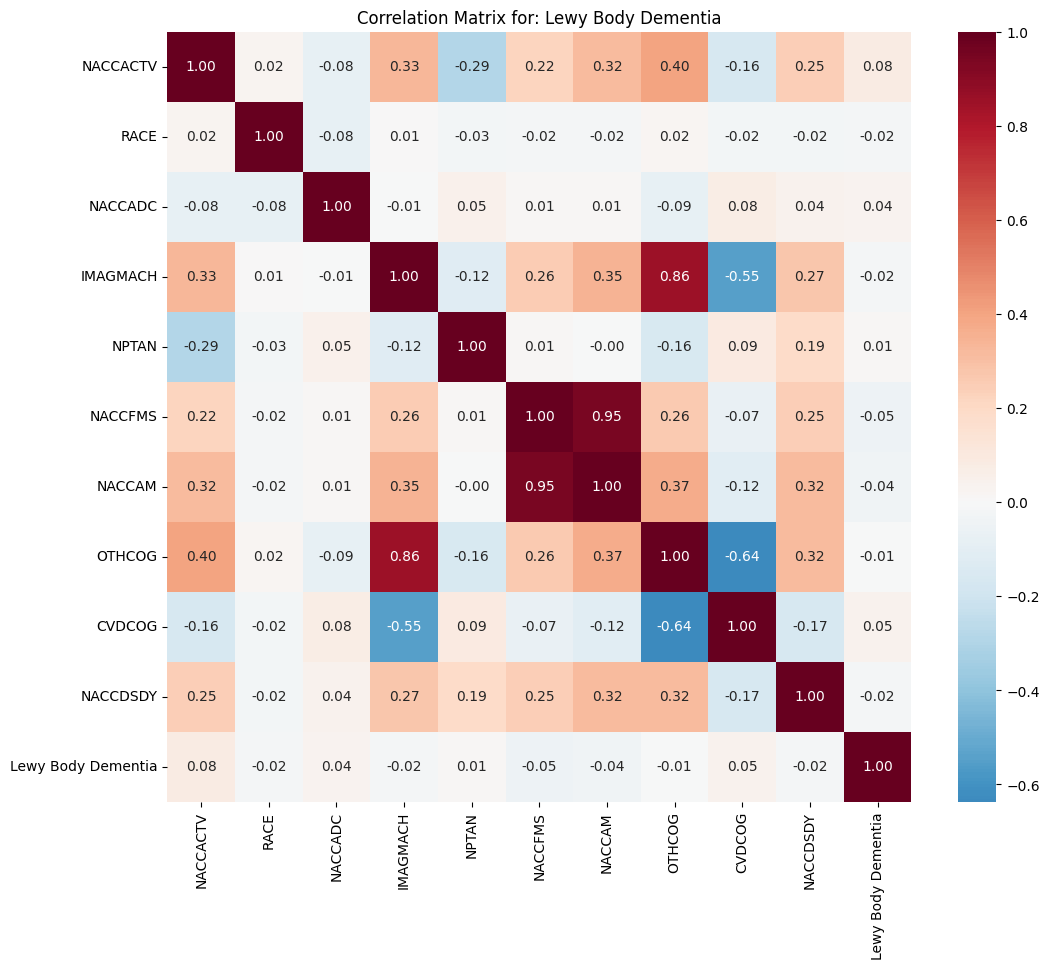

Top 10 features for Lewy Body Dementia: ['NACCACTV', 'RACE', 'NACCADC', 'IMAGMACH', 'NPTAN', 'NACCFMS', 'NACCAM', 'OTHCOG', 'CVDCOG', 'NACCDSDY']


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb

def corr_selection(X, y, disease_name, model, num_features=10, show=True):
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    top_features = feature_importances.head(num_features).index.tolist()
    selected_data = X[top_features].copy()
    selected_data[disease_name] = y
    if show:
        corr_filtered = selected_data.corr()
        plt.figure(figsize=(12, 10))
        # Correlation matrix: values range from -1 (strong negative) to 1 (strong positive),
        # have 0 as neutral. Center 0 to white, -1  dark blue,  1 as red.
        sns.heatmap(corr_filtered, cmap='RdBu_r', center=0, annot=True, fmt=".2f")
        plt.title(f"Correlation Matrix for: {disease_name}")
        plt.show()
    return top_features

for target_code in target_columns:
    y_target = y_train[target_code]
    disease_name = disease_names[target_code]
    best_params = best_params_dict[target_code].copy()
    best_params['random_state'] = 42
    best_params['use_label_encoder'] = False
    final_model = xgb.XGBClassifier(**best_params)
    final_model.fit(x_train, y_target)
    top_features = corr_selection(x_train, y_target, disease_name, final_model, num_features=10, show=True)
    print(f"Top 10 features for {disease_name}:", top_features)


## **PATHOLOGY PATIENT SUMMARY**

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:17:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:20:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:21:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:23:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:25:38] WARNING: /w

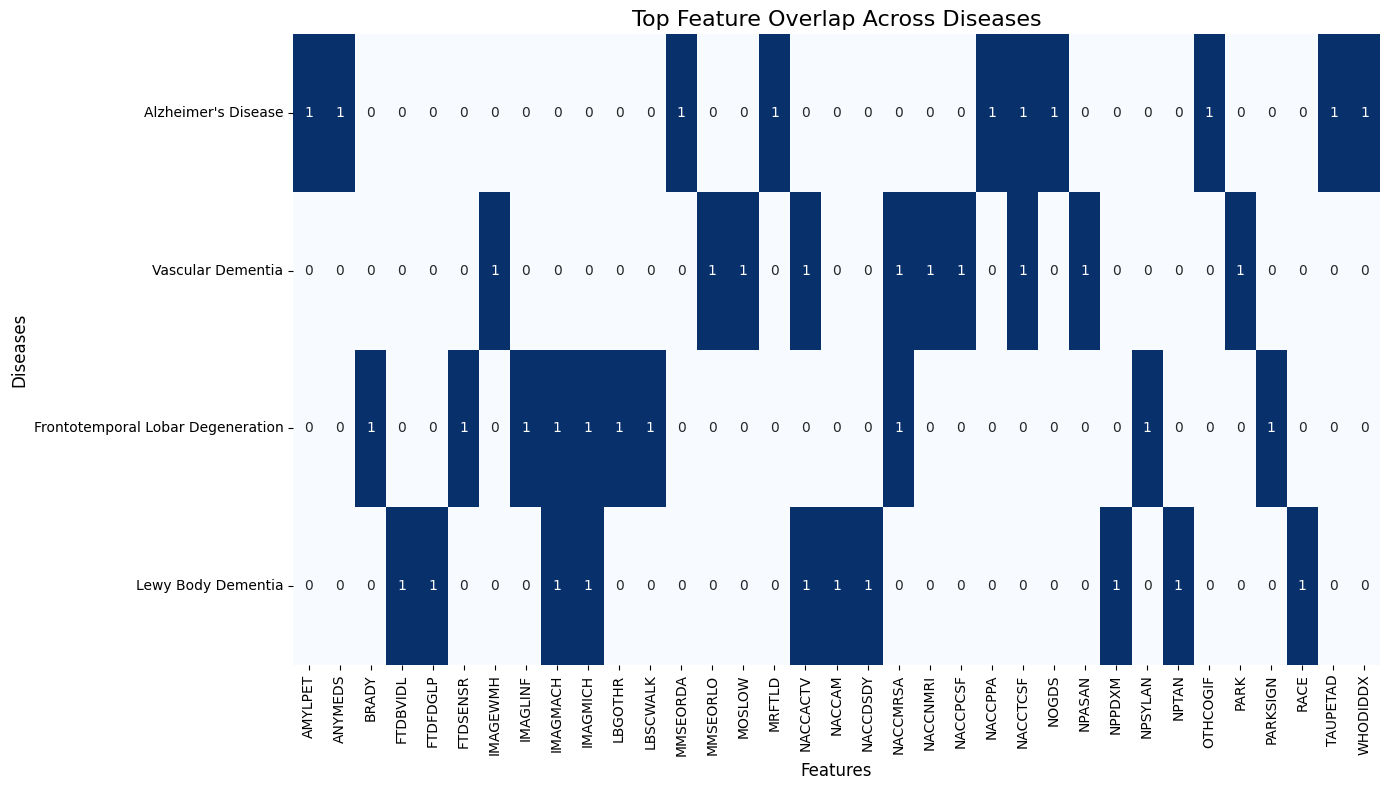

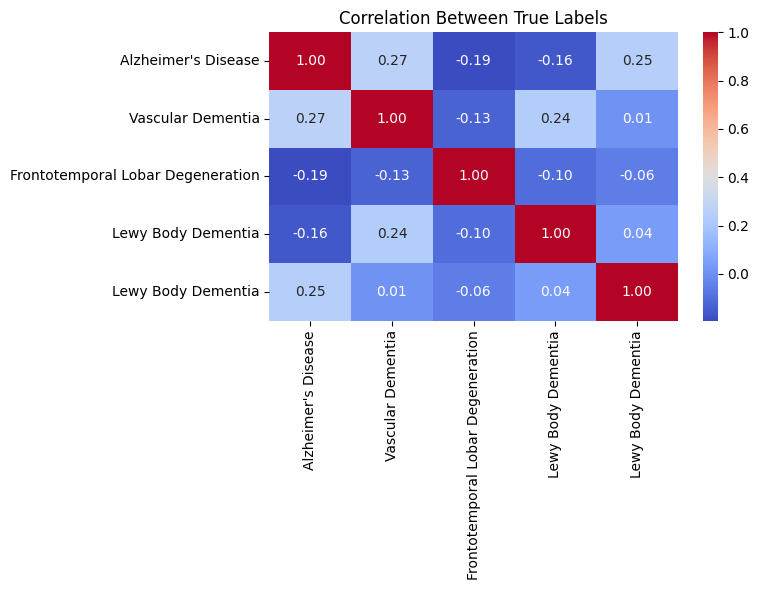

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:27:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:29:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:31:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:32:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:34:57] WARNING: /w

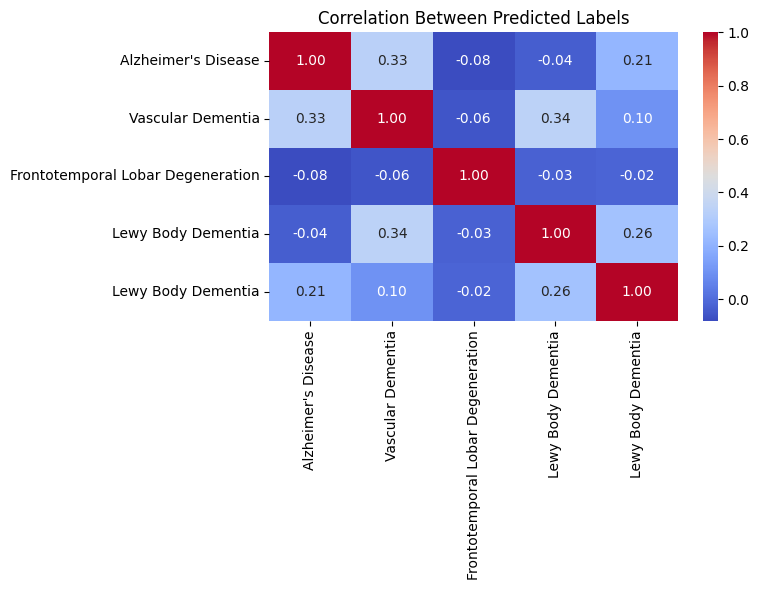

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:36:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:39:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:40:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:42:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:44:19] WARNING: /w

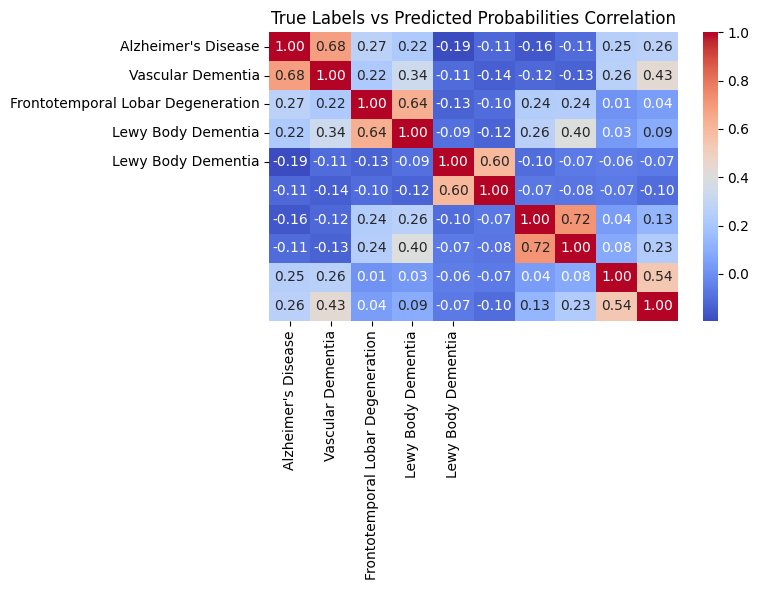


Patient Co-Pathology Overlap Counts:
0.0    9010
1.0    8937
2.0    6870
3.0     579
4.0     376
Name: count, dtype: int64


<ipython-input-23-de80d6b60eeb>:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=overlap_summary.index, y=overlap_summary.values, palette="Blues_d")


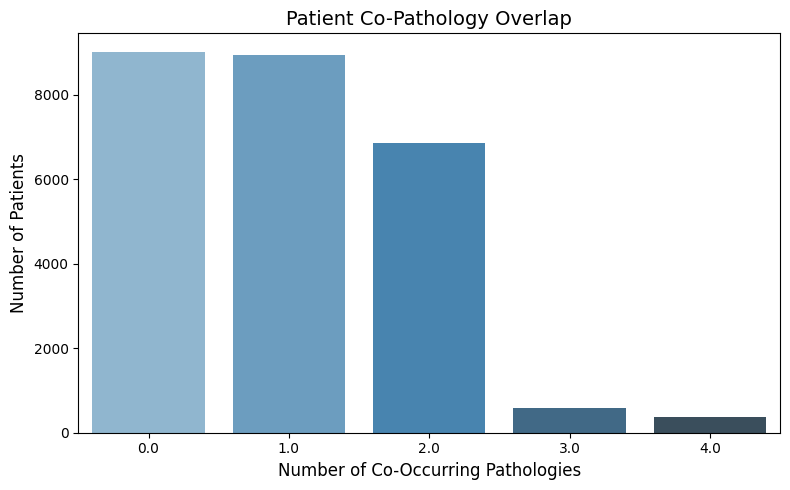

In [ ]:
# -------------------------------------------------------------
# 8. Cross-Pathology Correlation & Co-Occurrence Analysis
# -------------------------------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

# -------- (0) Top Features per Disease from XGBoost Models --------
# This regenerates the top_features_dict from scratch using your existing params & training loops
top_features_dict = {}

for col in target_columns:
    clf = xgb.XGBClassifier(n_jobs=-1, **best_params_dict[col],
                            random_state=42, use_label_encoder=False, objective='binary:logistic')
    clf.fit(x_train[feature_subset], y_train[col])

    # Get top 10 features by importance
    importances = clf.feature_importances_
    top_idxs = np.argsort(importances)[-10:]
    top_features = x_train[feature_subset].columns[top_idxs].tolist()

    top_features_dict[col] = top_features

# -------- (1) Top Feature Overlap Across Diseases --------
renamed_top_features = {disease_names[k]: v for k, v in top_features_dict.items()}
all_features = np.unique(np.concatenate(list(renamed_top_features.values())))
overlap_df = pd.DataFrame(0, index=renamed_top_features.keys(), columns=all_features)

for disease, features in renamed_top_features.items():
    overlap_df.loc[disease, features] = 1

plt.figure(figsize=(14, 8))
sns.heatmap(overlap_df, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Top Feature Overlap Across Diseases", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Diseases", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# -------- (2) Correlation Between True Labels --------
true_corr = y_test[target_columns].corr()

plt.figure(figsize=(8,6))
sns.heatmap(true_corr, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=[disease_names[c] for c in target_columns],
            yticklabels=[disease_names[c] for c in target_columns])
plt.title("Correlation Between True Labels")
plt.tight_layout()
plt.show()

# -------- (3) Correlation Between Model Predictions (Binary) --------
y_pred_binary = pd.DataFrame(index=y_test.index)

for col in target_columns:
    clf = xgb.XGBClassifier(n_jobs=-1, **best_params_dict[col],
                            random_state=42, use_label_encoder=False, objective='binary:logistic')
    clf.fit(x_train[feature_subset], y_train[col])
    y_pred_binary[col] = clf.predict(x_test[feature_subset])

pred_corr = y_pred_binary.corr()

plt.figure(figsize=(8,6))
sns.heatmap(pred_corr, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=[disease_names[c] for c in target_columns],
            yticklabels=[disease_names[c] for c in target_columns])
plt.title("Correlation Between Predicted Labels")
plt.tight_layout()
plt.show()

# -------- (4) Correlation: True Labels vs Predicted Probabilities --------
y_pred_proba = pd.DataFrame(index=y_test.index)

for col in target_columns:
    clf = xgb.XGBClassifier(n_jobs=-1, **best_params_dict[col],
                            random_state=42, use_label_encoder=False, objective='binary:logistic')
    clf.fit(x_train[feature_subset], y_train[col])
    y_pred_proba[col] = clf.predict_proba(x_test[feature_subset])[:,1]

cross_corr = pd.concat([y_test[target_columns], y_pred_proba], axis=1).corr()
cross_corr_matrix = cross_corr.loc[target_columns, target_columns]

plt.figure(figsize=(8,6))
sns.heatmap(cross_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=[disease_names[c] for c in target_columns],
            yticklabels=[disease_names[c] for c in target_columns])
plt.title("True Labels vs Predicted Probabilities Correlation")
plt.tight_layout()
plt.show()

# -------- (5) Co-Pathology Overlap by Patient --------
co_pathology_counts = y_test[target_columns].sum(axis=1)
overlap_summary = co_pathology_counts.value_counts().sort_index()

print("\nPatient Co-Pathology Overlap Counts:")
print(overlap_summary)

plt.figure(figsize=(8,5))
sns.barplot(x=overlap_summary.index, y=overlap_summary.values, palette="Blues_d")
plt.xlabel("Number of Co-Occurring Pathologies", fontsize=12)
plt.ylabel("Number of Patients", fontsize=12)
plt.title("Patient Co-Pathology Overlap", fontsize=14)
plt.tight_layout()
plt.show()


# ***HYPERPARAMETER OPTIMIZATION***

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from functools import reduce

# --------------------------
# Import machine learning libraries
# --------------------------
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import (
    StratifiedKFold, train_test_split
)
from sklearn.metrics import (
    classification_report, precision_recall_curve, auc, accuracy_score,
    f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.utils import resample
from sklearn.base import clone
from sklearn.utils.class_weight import compute_class_weight
from skopt.space import Real, Integer
from skopt import BayesSearchCV
from bayes_opt import BayesianOptimization

# --------------------------
# 1. Data Preprocessing
# --------------------------
print("Starting data preprocessing...")
# Assume pre_diagnosis_df is pre-loaded DataFrame and is valid
pre_diagnosis_df = pre_diagnosis_df.copy()

# Define target columns and split features vs targets
target_columns = ['NPPAD', 'NPCVASC', 'NPPFTLD', 'NPPLEWY', 'NPCLEWY']
features = pre_diagnosis_df.drop(columns=target_columns)
targets = pre_diagnosis_df[target_columns]
print("Splitting features and targets complete.")

# Clean and convert target values
def clean_target_values(df):
    print("Cleaning target values (replacing -4 and filling missing values)...")
    return df.replace(-4, np.nan).ffill().bfill()

def define_binary_labels(df):
    print("Converting target values to binary labels...")
    return df.replace({1.0: 1, 2.0: 0, 0.0: 0})

targets = clean_target_values(targets)
targets = define_binary_labels(targets)

# Ensure all features are numeric
print("Converting feature columns to numeric...")
features = features.apply(pd.to_numeric, errors='coerce')

# --------------------------
# 2. Advanced Missing Data Imputation
# --------------------------
print("Performing efficient imputation using IterativeImputer with Ridge estimator...")
imputer = IterativeImputer(
    estimator=Ridge(alpha=1.0),
    random_state=42,
    max_iter=3,
    tol=1e-1,
    initial_strategy='mean',
    imputation_order='ascending',
    n_nearest_features=20,
    skip_complete=True
)
features_imputed = pd.DataFrame(
    imputer.fit_transform(features),
    columns=features.columns,
    index=features.index
)
features_imputed = features_imputed.dropna()
targets = targets.loc[features_imputed.index]
print(f"Dataset dimensions after imputation: {features_imputed.shape}")

# --------------------------
# 3. Construct 'visit_date' Column
# --------------------------
print("Constructing 'visit_date' column from VISITYR...")
features_imputed['visit_date'] = pd.to_datetime(
    features_imputed['VISITYR'].astype(int).astype(str) + '-01-01',
    errors='coerce'
)
print("Visit date column constructed.")

# --------------------------
# 4. Model Training Setup & Hyperparameter Tuning Functions
# --------------------------

# Define SMOTE oversampling
smote = SMOTE(sampling_strategy=0.85, random_state=42)

# Example hyperparameter search space for reference (used in tuning functions)
search_spaces = {
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'max_depth': Integer(4, 6),
    'subsample': Real(0.75, 0.85),
    'colsample_bytree': Real(0.8, 0.9),
    'reg_alpha': Real(0, 0.1),
    'reg_lambda': Real(0.5, 1.0),
    'n_estimators': Integer(150, 200),
    'gamma': Real(0, 0.05),
    'min_child_weight': Integer(1, 2)
}

num_runs = 3
print(f"Number of runs set to {num_runs}.")

### Bayesian Optimization Function
def bo_tune_xgb(X, y):
    def xgb_eval(n_estimators, learning_rate, max_depth, gamma, min_child_weight, subsample, colsample_bytree, scale_pos_weight):
        params = {
            'n_estimators': int(n_estimators),
            'learning_rate': learning_rate,
            'max_depth': int(max_depth),
            'gamma': gamma,
            'min_child_weight': int(min_child_weight),
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'eval_metric': 'auc',
            'scale_pos_weight': scale_pos_weight
        }
        dtrain = xgb.DMatrix(X, label=y)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)
        cv_result = xgb.cv(
            params, dtrain, num_boost_round=1000, folds=cv,
            maximize=True, metrics="auc", early_stopping_rounds=10, seed=42
        )
        return cv_result['test-auc-mean'].max()

    optimizer = BayesianOptimization(
        f=xgb_eval,
        pbounds={
            'n_estimators': (50, 300),
            'learning_rate': (0.01, 0.2),
            'max_depth': (2, 10),
            'gamma': (0.01, 15),
            'min_child_weight': (1, 25),
            'subsample': (0.2, 1.0),
            'colsample_bytree': (0.2, 1.0),
            'scale_pos_weight': (sum(y == 0) / sum(y), sum(y == 0) / sum(y))
        },
        random_state=42,
        verbose=2
    )
    optimizer.maximize(init_points=10, n_iter=25)
    best_params = optimizer.max['params']
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['min_child_weight'] = int(best_params['min_child_weight'])
    # Add the objective parameter to best_params if needed.
    best_params['objective'] = 'binary:logistic'
    print(f"Optimal Parameters: {best_params}")
    return xgb.XGBClassifier(**best_params)

# Utility function to compute confidence intervals
def compute_ci(scores, ci=0.95):
    bootstrapped_scores = [np.mean(resample(scores, replace=True)) for _ in range(1000)]
    lower = np.percentile(bootstrapped_scores, (1 - ci) / 2 * 100)
    upper = np.percentile(bootstrapped_scores, (1 + ci) / 2 * 100)
    return lower, upper

cv_results = {}

# --------------------------
# 5. Temporal External Test Split
# --------------------------
print("Splitting data into training and external test sets...")
external_test_cutoff = datetime.datetime(2019, 6, 1)
train_mask = features_imputed['visit_date'] < external_test_cutoff
test_mask = features_imputed['visit_date'] >= external_test_cutoff

X_train_full = features_imputed[train_mask].drop(columns=['visit_date'])
X_test_external = features_imputed[test_mask].drop(columns=['visit_date'])
targets_train = targets.loc[X_train_full.index]
targets_external = targets.loc[X_test_external.index]
print(f"Train samples: {X_train_full.shape[0]}, External test samples: {X_test_external.shape[0]}")

# --------------------------
# 6. Internal Model Training with Cross-Validation and Bayesian Tuning
# --------------------------
print("Starting internal model training with cross-validation...")

for col in targets.columns:
    print(f"\nTraining model for target: {col}")
    X_internal = X_train_full.copy()
    y_internal = targets_train[col]

    # Perform hyperparameter tuning once for the target variable using Bayesian Optimization.
    tuned_model = bo_tune_xgb(X_internal, y_internal)
    tuned_params = tuned_model.get_params()
    print(f"Using tuned parameters for CV: {tuned_params}")

    auc_pr_scores_all, acc_scores_all, f1_scores_all, prec_scores_all, roc_auc_scores_all = [], [], [], [], []

    for run in range(num_runs):
        print(f"Run {run + 1}...")
        auc_pr_scores, acc_scores, f1_scores, prec_scores, roc_auc_scores = [], [], [], [], []
        kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42 + run)

        for train_idx, val_idx in kf.split(X_internal, y_internal):
            X_train_cv, X_val_cv = X_internal.iloc[train_idx], X_internal.iloc[val_idx]
            y_train_cv, y_val_cv = y_internal.iloc[train_idx], y_internal.iloc[val_idx]

            if len(np.unique(y_train_cv)) > 1:
                X_resampled, y_resampled = smote.fit_resample(X_train_cv, y_train_cv)
            else:
                X_resampled, y_resampled = X_train_cv, y_train_cv

            # Calculate scale_pos_weight for the current fold
            classes = np.unique(y_resampled)
            class_weights = compute_class_weight('balanced', classes=classes, y=y_resampled)
            weight_dict = dict(zip(classes, class_weights))
            scale_pos_weight = weight_dict.get(1, 1) / weight_dict.get(0, 1)
            tuned_params['scale_pos_weight'] = scale_pos_weight

            # Remove conflicting parameters to avoid multiple values error
            tuned_params.pop('objective', None)
            tuned_params.pop('random_state', None)

            # Instantiate model using tuned parameters with explicit settings
            model = xgb.XGBClassifier(**tuned_params, objective='binary:logistic',
                                      random_state=42, use_label_encoder=False)
            model.fit(X_resampled, y_resampled)
            y_pred_prob = model.predict_proba(X_val_cv)[:, 1]
            y_pred = model.predict(X_val_cv)

            precision_vals, recall_vals, _ = precision_recall_curve(y_val_cv, y_pred_prob)
            auc_pr = auc(recall_vals, precision_vals) if len(recall_vals) > 1 else 0
            roc_auc = roc_auc_score(y_val_cv, y_pred_prob)
            acc = accuracy_score(y_val_cv, y_pred)
            f1 = f1_score(y_val_cv, y_pred, zero_division=0)
            prec = precision_score(y_val_cv, y_pred, zero_division=0)

            auc_pr_scores.append(auc_pr)
            acc_scores.append(acc)
            f1_scores.append(f1)
            prec_scores.append(prec)
            roc_auc_scores.append(roc_auc)

        auc_pr_scores_all.append(np.mean(auc_pr_scores))
        acc_scores_all.append(np.mean(acc_scores))
        f1_scores_all.append(np.mean(f1_scores))
        prec_scores_all.append(np.mean(prec_scores))
        roc_auc_scores_all.append(np.mean(roc_auc_scores))

    print(f"Results for {col}:")
    print(f"AUC-PR: {np.mean(auc_pr_scores_all):.4f}, Accuracy: {np.mean(acc_scores_all):.4f}, "
          f"F1: {np.mean(f1_scores_all):.4f}, Precision: {np.mean(prec_scores_all):.4f}, "
          f"ROC AUC: {np.mean(roc_auc_scores_all):.4f}")
    cv_results[col] = {
        "auc_pr_mean": np.mean(auc_pr_scores_all),
        "acc_mean": np.mean(acc_scores_all),
        "f1_mean": np.mean(f1_scores_all),
        "prec_mean": np.mean(prec_scores_all),
        "roc_auc_mean": np.mean(roc_auc_scores_all)
    }

# --------------------------
# 7. Final External Test Evaluation Using Manually Provided Best Tuned Hyperparameters
# --------------------------
print("\nFinal External Test Evaluation Using Manually Provided Best Hyperparameters:\n")

# Manually provided best tuned hyperparameters for each target.
# (These values were obtained during your internal tuning for each target.)
best_params_dict = {
    'NPPAD': {
        'colsample_bytree': 0.2959052013119931,
        'gamma': 0.06645864723163242,
        'learning_rate': 0.07268496438341125,
        'max_depth': 9,
        'min_child_weight': 2,
        'n_estimators': 273,
        'scale_pos_weight': 1.4029422859298377,
        'subsample': 0.6724415296011144,
        'objective': 'binary:logistic'
    },
    'NPCVASC': {
        'colsample_bytree': 0.9027973532095548,
        'gamma': 0.30034316206063866,
        'learning_rate': 0.05931965434185861,
        'max_depth': 9,
        'min_child_weight': 11,
        'n_estimators': 174,
        'scale_pos_weight': 2.301477066597564,
        'subsample': 0.6109206665327078,
        'objective': 'binary:logistic'
    },
    'NPPFTLD': {
        'colsample_bytree': 0.7941471813064929,
        'gamma': 0.15872400429824549,
        'learning_rate': 0.11828681068934162,
        'max_depth': 5,
        'min_child_weight': 11,
        'n_estimators': 289,
        'scale_pos_weight': 16.587520706791828,
        'subsample': 0.7812118371899288,
        'objective': 'binary:logistic'
    },
    'NPPLEWY': {
        'colsample_bytree': 0.9596391600818355,
        'gamma': 0.26003516321998293,
        'learning_rate': 0.06455171801802792,
        'max_depth': 9,
        'min_child_weight': 21,
        'n_estimators': 282,
        'scale_pos_weight': 8.222817431591139,
        'subsample': 0.8563535347075413,
        'objective': 'binary:logistic'
    },
    'NPCLEWY': {
        'colsample_bytree': 0.5439586158174785,
        'gamma': 0.29133350032001704,
        'learning_rate': 0.036472916662562645,
        'max_depth': 7,
        'min_child_weight': 21,
        'n_estimators': 277,
        'scale_pos_weight': 6.968726544908682,
        'subsample': 0.6990078327466633,
        'objective': 'binary:logistic'
    }
}

# Define the performance metric function as specified.
def get_performance_metrics(model, X, y):
    predictions = model.predict(X)
    scores = model.predict_proba(X)[:,1]
    print(f'Accuracy: {accuracy_score(y, predictions)}')
    print(f'Precision: {precision_score(y, predictions)}')
    print(f'Recall/Sensitivity/TPR: {recall_score(y, predictions)}')
    print(f'Specificity/1-FPR: {recall_score(y, predictions, pos_label=0)}')
    print(f'ROC-AUC: {roc_auc_score(y, scores)}')
    print(f'PR-AUC: {average_precision_score(y, scores)}\n')

# Loop over each target to build the final model, train it, and evaluate on the external test set.
for col in targets.columns:
    print(f"\n*** Final Evaluation for target: {col} ***\n")

    # Retrieve the full training and external test sets for this target.
    X_train_final = X_train_full.copy()
    y_train_final = targets_train[col]
    X_test_final = X_test_external.copy()
    y_test_final = targets_external[col]

    # Retrieve the manually provided best tuned hyperparameters for this target.
    # Also add standard parameters: random_state and use_label_encoder.
    best_params = best_params_dict[col].copy()
    best_params['random_state'] = 42
    best_params['use_label_encoder'] = False

    # Build the final model using the provided hyperparameters.
    final_model = xgb.XGBClassifier(**best_params)
    final_model.fit(X_train_final, y_train_final)

    # Evaluate the final model on the external test set.
    get_performance_metrics(final_model, X_test_final, y_test_final)



Starting data preprocessing...
Splitting features and targets complete.
Cleaning target values (replacing -4 and filling missing values)...
Converting target values to binary labels...
Converting feature columns to numeric...
Performing efficient imputation using IterativeImputer with Ridge estimator...
Dataset dimensions after imputation: (73081, 863)
Constructing 'visit_date' column from VISITYR...
Visit date column constructed.
Number of runs set to 3.
Splitting data into training and external test sets...
Train samples: 63702, External test samples: 9379
Starting internal model training with cross-validation...

Training model for target: NPPAD
|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:36:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:36:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:37:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:37:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 1         | 0.764     | 0.4996    | 14.26     | 0.1491    | 6.789     | 4.744     | 89.0      | 1.403     | 0.8929    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:37:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:37:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:37:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:37:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 2         | 0.7528    | 0.6809    | 10.62     | 0.01391   | 9.759     | 20.98     | 103.1     | 1.403     | 0.3467    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:37:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:37:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:37:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 3         | 0.7629    | 0.4434    | 7.876     | 0.09207   | 4.33      | 15.68     | 84.87     | 1.403     | 0.4931    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:38:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:38:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:38:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:38:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 4         | 0.7411    | 0.5649    | 11.78     | 0.04794   | 6.114     | 15.22     | 61.61     | 1.403     | 0.3364    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:38:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:38:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:38:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:38:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 5         | 0.7409    | 0.252     | 14.23     | 0.1935    | 8.467     | 8.311     | 74.42     | 1.403     | 0.5521    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:39:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:39:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:39:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:39:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 6         | 0.7876    | 0.2976    | 7.433     | 0.01653   | 9.275     | 7.211     | 215.6     | 1.403     | 0.6161    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:40:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:40:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:40:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:40:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 7         | 0.8467    | 0.6374    | 2.781     | 0.1942    | 8.201     | 23.55     | 273.7     | 1.403     | 0.9375    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:40:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:40:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:40:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 8         | 0.7983    | 0.2708    | 2.948     | 0.01859   | 4.603     | 10.33     | 117.8     | 1.403     | 0.4854    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:43:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 9         | 0.7658    | 0.4247    | 8.145     | 0.03678   | 8.418     | 2.789     | 296.7     | 1.403     | 0.359     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:43:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:43:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:43:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:43:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 10        | 0.7227    | 0.2044    | 12.23     | 0.1443    | 7.832     | 19.51     | 68.51     | 1.403     | 0.2927    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:44:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:44:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:44:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 11        | 0.8624    | 0.4803    | 1.385     | 0.07108   | 7.026     | 22.47     | 259.9     | 1.403     | 0.3073    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:46:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:46:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:46:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 12        | 0.7251    | 0.7975    | 14.76     | 0.09222   | 2.69      | 22.74     | 253.2     | 1.403     | 0.624     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:46:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:46:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:46:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:46:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 13        | 0.841     | 0.3421    | 2.535     | 0.06623   | 7.233     | 23.74     | 274.2     | 1.403     | 0.9241    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:47:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:47:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:47:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:47:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 14        | 0.9166    | 0.9047    | 0.2743    | 0.1016    | 7.05      | 14.85     | 264.4     | 1.403     | 0.2859    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:50:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:50:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:50:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:50:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 15        | 0.9145    | 0.2967    | 0.4355    | 0.1875    | 8.191     | 2.617     | 268.3     | 1.403     | 0.7405    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:51:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:51:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:51:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:51:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 16        | 0.956     | 0.9116    | 0.07486   | 0.09409   | 8.866     | 3.22      | 257.2     | 1.403     | 0.5882    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:55:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:55:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:55:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:55:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 17        | 0.8468    | 0.287     | 0.08877   | 0.1995    | 5.275     | 1.346     | 243.0     | 1.403     | 0.22      |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:57:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:57:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:57:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:57:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 18        | 0.7942    | 0.3874    | 7.993     | 0.198     | 9.426     | 2.616     | 258.4     | 1.403     | 0.9594    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [18:57:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:57:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:58:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [18:58:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 19        | 0.8322    | 0.2731    | 0.0133    | 0.08412   | 3.203     | 4.743     | 258.1     | 1.403     | 0.4608    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 20        | 0.9306    | 0.3967    | 0.2664    | 0.1221    | 8.704     | 9.068     | 263.5     | 1.403     | 0.4966    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:02:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:02:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:02:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:02:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 21        | 0.8484    | 0.8627    | 2.546     | 0.1795    | 9.971     | 10.81     | 271.7     | 1.403     | 0.4838    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:03:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:03:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:03:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:03:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 22        | 0.842     | 0.7793    | 2.396     | 0.04647   | 9.908     | 11.37     | 257.8     | 1.403     | 0.3157    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:04:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:04:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:04:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:04:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 23        | 0.8668    | 0.7317    | 1.606     | 0.05081   | 7.602     | 2.571     | 262.9     | 1.403     | 0.3301    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:07:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:07:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:07:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:07:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 24        | 0.901     | 0.8422    | 1.02      | 0.05139   | 8.263     | 3.619     | 253.1     | 1.403     | 0.356     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:10:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:10:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:10:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 25        | 0.9135    | 0.9189    | 0.1208    | 0.171     | 4.022     | 8.574     | 268.6     | 1.403     | 0.9763    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:12:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:12:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:12:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:12:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 26        | 0.9281    | 0.6222    | 0.08095   | 0.1261    | 5.981     | 2.573     | 276.6     | 1.403     | 0.6906    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:15:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:15:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:15:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:15:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 27        | 0.7521    | 0.6991    | 7.296     | 0.08722   | 2.694     | 2.216     | 274.9     | 1.403     | 0.9561    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:16:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:16:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:16:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 28        | 0.9578    | 0.2959    | 0.06646   | 0.07268   | 9.754     | 2.519     | 273.9     | 1.403     | 0.6724    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:20:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:20:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:20:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:20:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 29        | 0.7059    | 0.7438    | 14.78     | 0.1242    | 8.5       | 23.62     | 165.4     | 1.403     | 0.2021    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:20:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:20:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:20:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:20:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 30        | 0.9485    | 0.5056    | 0.2515    | 0.02396   | 9.062     | 1.74      | 283.3     | 1.403     | 0.7298    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:24:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:24:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:24:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 31        | 0.8113    | 0.4287    | 1.261     | 0.1565    | 2.904     | 1.921     | 187.6     | 1.403     | 0.6245    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:26:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:26:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:26:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:26:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 32        | 0.9166    | 0.3056    | 0.5127    | 0.07405   | 9.928     | 8.658     | 284.3     | 1.403     | 0.3897    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:29:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:29:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:29:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:29:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 33        | 0.9118    | 0.4565    | 0.7053    | 0.1043    | 8.368     | 1.591     | 144.3     | 1.403     | 0.5853    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:31:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:31:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:31:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 34        | 0.7394    | 0.6196    | 11.51     | 0.07655   | 3.722     | 1.244     | 142.6     | 1.403     | 0.4952    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:31:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:31:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:31:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 35        | 0.9002    | 0.241     | 0.7267    | 0.1539    | 8.821     | 1.466     | 154.2     | 1.403     | 0.7425    |
Optimal Parameters: {'colsample_bytree': np.float64(0.2959052013119931), 'gamma': np.float64(0.06645864723163242), 'learning_rate': np.float64(0.07268496438341125), 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 273, 'scale_pos_weight': np.float64(1.4029422859298377), 'subsample': np.float64(0.6724415296011144), 'objective': 'binary:logistic'}
Using tuned parameters for CV: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': np.float64(0.2959052013119931), 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': np.float64(0.06645864723163242), 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': np.float64(0.072

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:32:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:33:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:33:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Run 2...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:33:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:34:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:34:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Run 3...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:34:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:35:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:35:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results for NPPAD:
AUC-PR: 0.8916, Accuracy: 0.8332, F1: 0.7899, Precision: 0.8302, ROC AUC: 0.9091

Training model for target: NPCVASC
|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:35:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:35:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:35:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 1         | 0.7831    | 0.4996    | 14.26     | 0.1491    | 6.789     | 4.744     | 89.0      | 2.301     | 0.8929    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:36:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:36:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:36:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 2         | 0.7743    | 0.6809    | 10.62     | 0.01391   | 9.759     | 20.98     | 103.1     | 2.301     | 0.3467    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:37:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:37:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:37:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 3         | 0.7857    | 0.4434    | 7.876     | 0.09207   | 4.33      | 15.68     | 84.87     | 2.301     | 0.4931    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:38:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:38:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:38:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:38:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 4         | 0.7601    | 0.5649    | 11.78     | 0.04794   | 6.114     | 15.22     | 61.61     | 2.301     | 0.3364    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:38:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:38:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:38:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 5         | 0.7609    | 0.252     | 14.23     | 0.1935    | 8.467     | 8.311     | 74.42     | 2.301     | 0.5521    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:38:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:38:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:38:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:38:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 6         | 0.7889    | 0.2976    | 7.433     | 0.01653   | 9.275     | 7.211     | 215.6     | 2.301     | 0.6161    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:39:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:39:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:39:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:39:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 7         | 0.8715    | 0.6374    | 2.781     | 0.1942    | 8.201     | 23.55     | 273.7     | 2.301     | 0.9375    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:39:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:39:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:39:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:39:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 8         | 0.8246    | 0.2708    | 2.948     | 0.01859   | 4.603     | 10.33     | 117.8     | 2.301     | 0.4854    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:41:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:41:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:41:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:41:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 9         | 0.7884    | 0.4247    | 8.145     | 0.03678   | 8.418     | 2.789     | 296.7     | 2.301     | 0.359     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:42:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:42:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:42:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 10        | 0.7389    | 0.2044    | 12.23     | 0.1443    | 7.832     | 19.51     | 68.51     | 2.301     | 0.2927    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:42:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:42:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:42:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:42:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 11        | 0.7902    | 0.5203    | 5.977     | 0.1444    | 7.09      | 24.9      | 262.6     | 2.301     | 0.2812    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:43:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:43:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 12        | 0.923     | 0.4176    | 0.3037    | 0.08886   | 9.009     | 20.27     | 277.9     | 2.301     | 0.2399    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:46:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:46:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:46:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:46:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 13        | 0.838     | 0.4161    | 3.14      | 0.01959   | 9.086     | 21.86     | 286.8     | 2.301     | 0.2238    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:49:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:49:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:49:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:49:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 14        | 0.8688    | 0.8024    | 2.066     | 0.1993    | 5.998     | 14.58     | 277.3     | 2.301     | 0.4903    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:49:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:49:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:49:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:49:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 15        | 0.8637    | 0.3613    | 0.1282    | 0.02065   | 5.243     | 20.77     | 279.2     | 2.301     | 0.9863    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:52:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:52:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:52:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:52:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 16        | 0.8405    | 0.9546    | 5.726     | 0.1438    | 9.365     | 20.8      | 277.7     | 2.301     | 0.7049    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:53:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:53:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:53:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:53:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 17        | 0.9433    | 0.2679    | 0.4527    | 0.05538   | 8.23      | 15.89     | 271.4     | 2.301     | 0.6667    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:56:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:56:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:56:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 18        | 0.9048    | 0.8475    | 1.517     | 0.183     | 8.959     | 9.07      | 266.6     | 2.301     | 0.6791    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:56:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:56:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:56:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:56:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 19        | 0.9372    | 0.7255    | 0.4471    | 0.134     | 7.843     | 1.689     | 255.0     | 2.301     | 0.503     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [19:59:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:59:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:59:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [19:59:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 20        | 0.7869    | 0.8845    | 5.048     | 0.04871   | 2.069     | 1.25      | 248.6     | 2.301     | 0.9436    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:01:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:01:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:01:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:01:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 21        | 0.9282    | 0.9421    | 0.1253    | 0.07663   | 5.111     | 1.224     | 263.8     | 2.301     | 0.5711    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:04:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:04:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:04:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 22        | 0.8304    | 0.8602    | 7.363     | 0.08803   | 8.863     | 1.045     | 261.4     | 2.301     | 0.8226    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:04:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:04:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:04:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 23        | 0.9046    | 0.6567    | 0.6912    | 0.1012    | 4.327     | 7.097     | 259.5     | 2.301     | 0.7068    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:07:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:07:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:07:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:07:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 24        | 0.952     | 0.3007    | 0.08187   | 0.1464    | 9.307     | 3.87      | 259.1     | 2.301     | 0.6297    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:09:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:09:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:09:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:09:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 25        | 0.721     | 0.3727    | 14.08     | 0.1975    | 2.828     | 23.48     | 162.8     | 2.301     | 0.3132    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:10:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:10:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:10:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:10:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 26        | 0.888     | 0.5251    | 2.74      | 0.14      | 9.093     | 1.109     | 142.2     | 2.301     | 0.8694    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:10:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:10:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:10:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:10:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 27        | 0.7257    | 0.4195    | 14.32     | 0.02075   | 2.24      | 1.584     | 132.8     | 2.301     | 0.3462    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:11:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:11:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:11:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 28        | 0.9376    | 0.9969    | 0.7728    | 0.02153   | 8.423     | 3.385     | 155.4     | 2.301     | 0.5802    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:15:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:15:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:15:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 29        | 0.9298    | 0.7146    | 0.4171    | 0.06449   | 7.108     | 2.124     | 170.6     | 2.301     | 0.2603    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:19:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:19:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:19:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:19:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 30        | 0.8172    | 0.3045    | 7.287     | 0.05441   | 9.206     | 1.256     | 163.7     | 2.301     | 0.6302    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:19:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:19:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:19:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 31        | 0.862     | 0.9563    | 1.644     | 0.1296    | 3.186     | 1.316     | 182.1     | 2.301     | 0.7397    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:22:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:22:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:22:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 32        | 0.9194    | 0.4753    | 0.01702   | 0.1156    | 6.933     | 11.6      | 148.9     | 2.301     | 0.2921    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:25:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:25:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:25:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 33        | 0.8234    | 0.4841    | 0.2326    | 0.1012    | 2.51      | 9.729     | 157.9     | 2.301     | 0.8851    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:27:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:27:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:27:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:27:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 34        | 0.9145    | 0.2484    | 0.4825    | 0.02556   | 9.624     | 19.09     | 142.5     | 2.301     | 0.2335    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:31:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:31:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:31:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 35        | 0.9568    | 0.9028    | 0.3003    | 0.05932   | 9.868     | 11.68     | 174.5     | 2.301     | 0.6109    |
Optimal Parameters: {'colsample_bytree': np.float64(0.9027973532095548), 'gamma': np.float64(0.30034316206063866), 'learning_rate': np.float64(0.05931965434185861), 'max_depth': 9, 'min_child_weight': 11, 'n_estimators': 174, 'scale_pos_weight': np.float64(2.301477066597564), 'subsample': np.float64(0.6109206665327078), 'objective': 'binary:logistic'}
Using tuned parameters for CV: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': np.float64(0.9027973532095548), 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': np.float64(0.30034316206063866), 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': np.float64(0.059

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:34:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:34:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:35:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Run 2...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:35:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:35:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:35:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Run 3...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:36:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:36:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:36:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results for NPCVASC:
AUC-PR: 0.7953, Accuracy: 0.8257, F1: 0.6558, Precision: 0.8158, ROC AUC: 0.8817

Training model for target: NPPFTLD
|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:37:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:37:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:37:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:37:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 1         | 0.9226    | 0.4996    | 14.26     | 0.1491    | 6.789     | 4.744     | 89.0      | 16.59     | 0.8929    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:37:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:37:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:37:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 2         | 0.9295    | 0.6809    | 10.62     | 0.01391   | 9.759     | 20.98     | 103.1     | 16.59     | 0.3467    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:39:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:39:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:39:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:39:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 3         | 0.9271    | 0.4434    | 7.876     | 0.09207   | 4.33      | 15.68     | 84.87     | 16.59     | 0.4931    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:41:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:41:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:41:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:41:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 4         | 0.9179    | 0.5649    | 11.78     | 0.04794   | 6.114     | 15.22     | 61.61     | 16.59     | 0.3364    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:42:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:42:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:42:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:42:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 5         | 0.9068    | 0.252     | 14.23     | 0.1935    | 8.467     | 8.311     | 74.42     | 16.59     | 0.5521    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:42:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:42:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:42:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:42:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 6         | 0.9415    | 0.2976    | 7.433     | 0.01653   | 9.275     | 7.211     | 215.6     | 16.59     | 0.6161    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:44:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:44:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:44:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:44:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 7         | 0.9466    | 0.6374    | 2.781     | 0.1942    | 8.201     | 23.55     | 273.7     | 16.59     | 0.9375    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:44:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:44:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:44:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:44:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 8         | 0.9284    | 0.2708    | 2.948     | 0.01859   | 4.603     | 10.33     | 117.8     | 16.59     | 0.4854    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:47:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:47:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:47:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:47:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 9         | 0.9318    | 0.4247    | 8.145     | 0.03678   | 8.418     | 2.789     | 296.7     | 16.59     | 0.359     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:48:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:48:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:48:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:48:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 10        | 0.8991    | 0.2044    | 12.23     | 0.1443    | 7.832     | 19.51     | 68.51     | 16.59     | 0.2927    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:49:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:49:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:49:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:49:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 11        | 0.9441    | 0.98      | 4.59      | 0.1253    | 8.149     | 16.34     | 280.6     | 16.59     | 0.6255    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:49:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:49:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:49:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 12        | 0.8953    | 0.3677    | 14.26     | 0.09756   | 2.743     | 21.28     | 273.6     | 16.59     | 0.7038    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:51:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:51:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:51:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 13        | 0.9537    | 0.3421    | 2.535     | 0.06623   | 7.233     | 23.74     | 274.2     | 16.59     | 0.9241    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:52:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:52:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:52:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:52:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 14        | 0.9471    | 0.4047    | 2.269     | 0.06514   | 4.503     | 21.03     | 276.9     | 16.59     | 0.3658    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:54:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:54:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:54:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 15        | 0.9477    | 0.9971    | 1.705     | 0.08905   | 3.272     | 23.27     | 273.1     | 16.59     | 0.5926    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:57:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:57:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:57:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:57:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 16        | 0.9463    | 0.6412    | 1.1       | 0.1539    | 6.044     | 23.9      | 279.5     | 16.59     | 0.3164    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [20:58:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:58:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:58:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [20:58:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 17        | 0.9612    | 0.2075    | 1.463     | 0.01918   | 9.756     | 15.69     | 288.5     | 16.59     | 0.5954    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:01:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:01:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:01:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 18        | 0.9681    | 0.7941    | 0.1587    | 0.1183    | 5.465     | 11.26     | 289.3     | 16.59     | 0.7812    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:03:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:03:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:03:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:03:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 19        | 0.9331    | 0.8059    | 3.165     | 0.1614    | 3.276     | 15.72     | 293.1     | 16.59     | 0.9457    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:04:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:04:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:04:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:04:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 20        | 0.9546    | 0.9356    | 0.8751    | 0.1834    | 7.868     | 9.389     | 285.5     | 16.59     | 0.5615    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:05:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:05:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:05:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 21        | 0.9588    | 0.9662    | 0.18      | 0.1655    | 9.235     | 10.63     | 291.3     | 16.59     | 0.7122    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:06:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:06:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:06:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:06:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 22        | 0.9631    | 0.9618    | 0.1815    | 0.09507   | 4.81      | 5.571     | 289.5     | 16.59     | 0.789     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:09:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:09:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:09:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 23        | 0.9265    | 0.5883    | 0.1458    | 0.1385    | 2.452     | 1.023     | 284.8     | 16.59     | 0.4748    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:11:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:11:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:11:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:11:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 24        | 0.9307    | 0.4577    | 5.253     | 0.0607    | 3.481     | 8.443     | 289.2     | 16.59     | 0.4256    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:13:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:13:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:14:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:14:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 25        | 0.9227    | 0.9591    | 0.01105   | 0.07972   | 2.221     | 16.08     | 283.5     | 16.59     | 0.6167    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:16:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:16:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:16:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:16:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 26        | 0.9362    | 0.226     | 0.161     | 0.1825    | 3.64      | 6.1       | 294.7     | 16.59     | 0.5004    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:18:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:18:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:18:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:18:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 27        | 0.9463    | 0.9371    | 3.618     | 0.1326    | 9.903     | 21.74     | 290.5     | 16.59     | 0.5745    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:18:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:18:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:18:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:18:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 28        | 0.9632    | 0.7401    | 0.2062    | 0.1399    | 8.723     | 4.267     | 289.9     | 16.59     | 0.6718    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:19:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:19:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:19:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 29        | 0.9275    | 0.7452    | 11.87     | 0.1002    | 7.936     | 9.217     | 203.3     | 16.59     | 0.5791    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:20:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:20:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:20:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:20:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 30        | 0.9513    | 0.8789    | 3.481     | 0.02829   | 9.403     | 4.893     | 226.8     | 16.59     | 0.3221    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:22:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:22:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 31        | 0.938     | 0.6854    | 11.6      | 0.04001   | 8.582     | 2.889     | 226.4     | 16.59     | 0.7817    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:23:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:23:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:23:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 32        | 0.9453    | 0.2896    | 0.02162   | 0.1565    | 8.959     | 12.63     | 227.9     | 16.59     | 0.4287    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:24:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:24:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:24:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 33        | 0.918     | 0.4482    | 0.9674    | 0.1853    | 2.199     | 5.222     | 223.0     | 16.59     | 0.4028    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:25:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:25:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:25:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:25:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 34        | 0.9604    | 0.3474    | 1.802     | 0.04277   | 9.149     | 2.828     | 234.4     | 16.59     | 0.7954    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:26:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:27:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:27:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:27:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 35        | 0.9579    | 0.4797    | 3.736     | 0.0415    | 9.516     | 7.505     | 236.5     | 16.59     | 0.9213    |
Optimal Parameters: {'colsample_bytree': np.float64(0.7941471813064929), 'gamma': np.float64(0.15872400429824549), 'learning_rate': np.float64(0.11828681068934162), 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 289, 'scale_pos_weight': np.float64(16.587520706791828), 'subsample': np.float64(0.7812118371899288), 'objective': 'binary:logistic'}
Using tuned parameters for CV: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': np.float64(0.7941471813064929), 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': np.float64(0.15872400429824549), 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': np.float64(0.11

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:27:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:28:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:28:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Run 2...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:28:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:29:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:29:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Run 3...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:29:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:29:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:30:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results for NPPFTLD:
AUC-PR: 0.5924, Accuracy: 0.9547, F1: 0.4546, Precision: 0.7219, ROC AUC: 0.9403

Training model for target: NPPLEWY
|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:30:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:30:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:30:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:30:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 1         | 0.8697    | 0.4996    | 14.26     | 0.1491    | 6.789     | 4.744     | 89.0      | 8.223     | 0.8929    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:30:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:30:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:30:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 2         | 0.8773    | 0.6809    | 10.62     | 0.01391   | 9.759     | 20.98     | 103.1     | 8.223     | 0.3467    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:32:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:32:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:32:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:32:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 3         | 0.8778    | 0.4434    | 7.876     | 0.09207   | 4.33      | 15.68     | 84.87     | 8.223     | 0.4931    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:33:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:33:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:33:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 4         | 0.858     | 0.5649    | 11.78     | 0.04794   | 6.114     | 15.22     | 61.61     | 8.223     | 0.3364    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:34:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:34:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:34:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 5         | 0.8541    | 0.252     | 14.23     | 0.1935    | 8.467     | 8.311     | 74.42     | 8.223     | 0.5521    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:34:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:34:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:34:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 6         | 0.9109    | 0.2976    | 7.433     | 0.01653   | 9.275     | 7.211     | 215.6     | 8.223     | 0.6161    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:36:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:36:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:36:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:36:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 7         | 0.9281    | 0.6374    | 2.781     | 0.1942    | 8.201     | 23.55     | 273.7     | 8.223     | 0.9375    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:36:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:36:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:36:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 8         | 0.8883    | 0.2708    | 2.948     | 0.01859   | 4.603     | 10.33     | 117.8     | 8.223     | 0.4854    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:39:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:39:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:39:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:39:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 9         | 0.8858    | 0.4247    | 8.145     | 0.03678   | 8.418     | 2.789     | 296.7     | 8.223     | 0.359     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:40:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:40:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:40:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 10        | 0.8334    | 0.2044    | 12.23     | 0.1443    | 7.832     | 19.51     | 68.51     | 8.223     | 0.2927    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:40:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:40:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:40:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:40:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 11        | 0.8995    | 0.7795    | 4.182     | 0.1429    | 7.646     | 17.8      | 263.6     | 8.223     | 0.2867    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:41:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:41:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:41:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:41:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 12        | 0.8965    | 0.2246    | 8.815     | 0.1198    | 8.529     | 24.87     | 283.0     | 8.223     | 0.8086    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:42:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:42:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:42:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:42:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 13        | 0.9344    | 0.3421    | 2.535     | 0.06623   | 7.233     | 23.74     | 274.2     | 8.223     | 0.9241    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:43:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:43:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:43:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 14        | 0.8383    | 0.9381    | 0.352     | 0.02651   | 2.318     | 18.68     | 273.6     | 8.223     | 0.2752    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:45:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:45:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:45:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 15        | 0.9225    | 0.2379    | 0.4206    | 0.1658    | 9.904     | 23.26     | 276.4     | 8.223     | 0.3377    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:46:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:46:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:46:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 16        | 0.9166    | 0.466     | 4.265     | 0.09659   | 6.504     | 23.96     | 276.4     | 8.223     | 0.7737    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:47:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:47:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:47:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:47:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 17        | 0.8976    | 0.3436    | 4.097     | 0.09012   | 4.473     | 24.78     | 270.1     | 8.223     | 0.3529    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:48:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:48:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:48:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 18        | 0.9475    | 0.2845    | 0.2234    | 0.186     | 6.98      | 24.14     | 280.3     | 8.223     | 0.5196    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:50:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:50:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:50:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:51:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 19        | 0.954     | 0.7194    | 1.128     | 0.05498   | 8.708     | 24.65     | 285.4     | 8.223     | 0.9439    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:52:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:52:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:52:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:52:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 20        | 0.8506    | 0.6413    | 1.347     | 0.01318   | 3.56      | 23.28     | 286.7     | 8.223     | 0.8732    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:54:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:54:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:54:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:54:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 21        | 0.9291    | 0.6797    | 3.385     | 0.1629    | 8.93      | 24.78     | 282.8     | 8.223     | 0.8144    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:55:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:55:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:55:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:55:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 22        | 0.9709    | 0.9596    | 0.26      | 0.06455   | 9.977     | 21.6      | 283.0     | 8.223     | 0.8564    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:57:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:57:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:57:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 23        | 0.948     | 0.2202    | 1.543     | 0.07205   | 8.848     | 17.94     | 283.0     | 8.223     | 0.7663    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:58:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:58:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:58:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:58:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 24        | 0.9049    | 0.3078    | 2.565     | 0.1399    | 9.767     | 16.22     | 290.4     | 8.223     | 0.2827    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [21:59:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:59:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:59:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [21:59:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 25        | 0.9452    | 0.4623    | 1.779     | 0.05788   | 8.432     | 10.11     | 283.4     | 8.223     | 0.538     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:01:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:01:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:01:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:01:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 26        | 0.8985    | 0.3906    | 6.827     | 0.05479   | 8.523     | 9.458     | 279.4     | 8.223     | 0.4105    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:02:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:02:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:02:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:02:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 27        | 0.9419    | 0.2319    | 0.7547    | 0.1343    | 8.316     | 5.221     | 286.3     | 8.223     | 0.5003    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:03:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:03:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:03:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:03:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 28        | 0.882     | 0.5609    | 0.6236    | 0.03176   | 3.851     | 5.223     | 283.0     | 8.223     | 0.916     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:05:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:05:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:05:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 29        | 0.9286    | 0.528     | 3.808     | 0.132     | 9.872     | 7.289     | 287.1     | 8.223     | 0.8812    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:06:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:06:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:06:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:06:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 30        | 0.9616    | 0.2265    | 0.5317    | 0.04502   | 9.971     | 19.94     | 285.9     | 8.223     | 0.5385    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:09:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:09:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:09:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:09:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 31        | 0.8268    | 0.9463    | 12.85     | 0.187     | 6.255     | 1.816     | 204.8     | 8.223     | 0.2001    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:09:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:09:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:09:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:09:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 32        | 0.9188    | 0.4503    | 3.03      | 0.1317    | 6.902     | 11.78     | 225.1     | 8.223     | 0.9704    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:10:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:10:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:10:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 33        | 0.8692    | 0.9668    | 8.098     | 0.08909   | 9.388     | 2.788     | 227.9     | 8.223     | 0.2066    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:10:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:10:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:10:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:10:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 34        | 0.8971    | 0.631     | 1.671     | 0.05085   | 3.149     | 16.09     | 217.3     | 8.223     | 0.4932    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:13:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:13:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:13:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:13:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 35        | 0.961     | 0.8049    | 0.219     | 0.1562    | 8.781     | 12.32     | 286.6     | 8.223     | 0.7648    |
Optimal Parameters: {'colsample_bytree': np.float64(0.9596391600818355), 'gamma': np.float64(0.26003516321998293), 'learning_rate': np.float64(0.06455171801802792), 'max_depth': 9, 'min_child_weight': 21, 'n_estimators': 282, 'scale_pos_weight': np.float64(8.222817431591139), 'subsample': np.float64(0.8563535347075413), 'objective': 'binary:logistic'}
Using tuned parameters for CV: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': np.float64(0.9596391600818355), 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': np.float64(0.26003516321998293), 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': np.float64(0.064

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:14:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:15:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:15:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Run 2...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:16:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:16:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:16:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Run 3...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:17:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:17:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:18:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results for NPPLEWY:
AUC-PR: 0.7037, Accuracy: 0.9238, F1: 0.5068, Precision: 0.8501, ROC AUC: 0.9320

Training model for target: NPCLEWY
|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:18:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:18:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:18:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:18:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 1         | 0.8359    | 0.4996    | 14.26     | 0.1491    | 6.789     | 4.744     | 89.0      | 6.969     | 0.8929    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:19:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:19:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:19:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 2         | 0.8388    | 0.6809    | 10.62     | 0.01391   | 9.759     | 20.98     | 103.1     | 6.969     | 0.3467    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:20:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:20:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:20:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:20:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 3         | 0.8461    | 0.4434    | 7.876     | 0.09207   | 4.33      | 15.68     | 84.87     | 6.969     | 0.4931    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:21:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:21:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:21:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:21:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 4         | 0.8211    | 0.5649    | 11.78     | 0.04794   | 6.114     | 15.22     | 61.61     | 6.969     | 0.3364    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:22:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:22:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:22:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 5         | 0.8075    | 0.252     | 14.23     | 0.1935    | 8.467     | 8.311     | 74.42     | 6.969     | 0.5521    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:23:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:23:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:23:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:23:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 6         | 0.8808    | 0.2976    | 7.433     | 0.01653   | 9.275     | 7.211     | 215.6     | 6.969     | 0.6161    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:24:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:24:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:24:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:24:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 7         | 0.9109    | 0.6374    | 2.781     | 0.1942    | 8.201     | 23.55     | 273.7     | 6.969     | 0.9375    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:25:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:25:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:25:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:25:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 8         | 0.8565    | 0.2708    | 2.948     | 0.01859   | 4.603     | 10.33     | 117.8     | 6.969     | 0.4854    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:27:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:27:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:27:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:27:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 9         | 0.8521    | 0.4247    | 8.145     | 0.03678   | 8.418     | 2.789     | 296.7     | 6.969     | 0.359     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:28:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:28:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:28:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:28:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 10        | 0.7863    | 0.2044    | 12.23     | 0.1443    | 7.832     | 19.51     | 68.51     | 6.969     | 0.2927    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:29:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:29:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:29:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:29:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 11        | 0.8812    | 0.501     | 2.347     | 0.1687    | 6.072     | 14.37     | 270.9     | 6.969     | 0.2535    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:30:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:30:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:30:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:30:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 12        | 0.8573    | 0.2246    | 8.815     | 0.1198    | 8.529     | 24.87     | 283.0     | 6.969     | 0.8086    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:31:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:31:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:31:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:31:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 13        | 0.9175    | 0.3421    | 2.535     | 0.06623   | 7.233     | 23.74     | 274.2     | 6.969     | 0.9241    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:32:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:32:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:32:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:32:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 14        | 0.7931    | 0.7313    | 4.079     | 0.02127   | 2.398     | 24.23     | 266.7     | 6.969     | 0.9072    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:34:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:34:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:34:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:34:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 15        | 0.8996    | 0.7802    | 4.612     | 0.138     | 7.052     | 20.43     | 276.6     | 6.969     | 0.8982    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:34:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:34:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:34:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:34:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 16        | 0.96      | 0.544     | 0.2913    | 0.03647   | 7.288     | 21.37     | 277.3     | 6.969     | 0.699     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:38:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:38:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:38:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:38:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 17        | 0.8321    | 0.8239    | 0.2342    | 0.01784   | 3.037     | 22.98     | 280.9     | 6.969     | 0.7716    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:40:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:40:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:40:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:40:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 18        | 0.9368    | 0.4808    | 2.107     | 0.04013   | 9.701     | 22.13     | 278.8     | 6.969     | 0.9073    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:42:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:42:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:42:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:42:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 19        | 0.9061    | 0.5445    | 1.045     | 0.1215    | 8.821     | 17.6      | 277.6     | 6.969     | 0.2157    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:43:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:43:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:43:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 20        | 0.9442    | 0.547     | 0.6332    | 0.04497   | 9.244     | 21.54     | 276.8     | 6.969     | 0.2737    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:47:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:47:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:47:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:47:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 21        | 0.9189    | 0.9462    | 4.107     | 0.04259   | 8.543     | 17.86     | 213.5     | 6.969     | 0.7864    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:48:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:48:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:48:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:48:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 22        | 0.8066    | 0.3189    | 3.377     | 0.03367   | 2.65      | 16.66     | 216.4     | 6.969     | 0.5418    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:50:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:50:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:50:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:50:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 23        | 0.9009    | 0.6193    | 4.358     | 0.1739    | 9.913     | 22.64     | 211.5     | 6.969     | 0.9655    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:50:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:50:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:51:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:51:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 24        | 0.895     | 0.8974    | 3.713     | 0.09744   | 9.386     | 14.75     | 207.7     | 6.969     | 0.305     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:51:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:51:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:52:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:52:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 25        | 0.8509    | 0.3795    | 10.29     | 0.02658   | 9.577     | 18.04     | 214.6     | 6.969     | 0.519     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:52:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:52:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:53:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 26        | 0.9138    | 0.9143    | 0.4809    | 0.1817    | 6.922     | 20.56     | 209.3     | 6.969     | 0.2904    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:54:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:54:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:54:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 27        | 0.9595    | 0.3537    | 0.6009    | 0.04087   | 9.293     | 15.77     | 212.3     | 6.969     | 0.7103    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:57:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:57:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:57:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 28        | 0.8867    | 0.2399    | 1.108     | 0.1747    | 9.699     | 9.641     | 212.6     | 6.969     | 0.2626    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [22:59:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:59:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [22:59:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 29        | 0.9132    | 0.7753    | 1.009     | 0.1162    | 9.863     | 20.89     | 215.5     | 6.969     | 0.2471    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:00:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:00:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:00:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 30        | 0.9302    | 0.8051    | 2.118     | 0.05469   | 7.924     | 24.07     | 199.5     | 6.969     | 0.8847    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:02:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:02:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:02:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 31        | 0.9178    | 0.9316    | 0.8749    | 0.09747   | 4.081     | 20.29     | 196.5     | 6.969     | 0.3364    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:04:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:04:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:04:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:04:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 32        | 0.9285    | 0.9799    | 2.03      | 0.06907   | 9.697     | 24.04     | 192.3     | 6.969     | 0.3784    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:06:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:06:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:06:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 33        | 0.8681    | 0.3239    | 7.202     | 0.08357   | 6.563     | 24.84     | 195.0     | 6.969     | 0.928     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:07:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:07:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:07:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 34        | 0.9436    | 0.6483    | 0.72      | 0.08093   | 9.963     | 16.37     | 197.0     | 6.969     | 0.4043    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:09:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:09:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:09:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:09:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 35        | 0.9392    | 0.5557    | 1.722     | 0.04681   | 8.612     | 18.38     | 190.9     | 6.969     | 0.9147    |
Optimal Parameters: {'colsample_bytree': np.float64(0.5439586158174785), 'gamma': np.float64(0.29133350032001704), 'learning_rate': np.float64(0.036472916662562645), 'max_depth': 7, 'min_child_weight': 21, 'n_estimators': 277, 'scale_pos_weight': np.float64(6.968726544908682), 'subsample': np.float64(0.6990078327466633), 'objective': 'binary:logistic'}
Using tuned parameters for CV: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': np.float64(0.5439586158174785), 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': np.float64(0.29133350032001704), 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': np.float64(0.03

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:10:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:10:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:11:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Run 2...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:11:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:12:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:12:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Run 3...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:12:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:13:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:13:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results for NPCLEWY:
AUC-PR: 0.5493, Accuracy: 0.8908, F1: 0.2624, Precision: 0.8625, ROC AUC: 0.8498

Final Results Summary & External Test Performance:

*** Evaluation for target: NPPAD ***

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:13:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:13:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:13:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:13:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 1         | 0.764     | 0.4996    | 14.26     | 0.1491    | 6.789     | 4.744     | 89.0      | 1.403     | 0.8929    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:13:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:14:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:14:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:14:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 2         | 0.7528    | 0.6809    | 10.62     | 0.01391   | 9.759     | 20.98     | 103.1     | 1.403     | 0.3467    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:14:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:14:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:14:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:14:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 3         | 0.7629    | 0.4434    | 7.876     | 0.09207   | 4.33      | 15.68     | 84.87     | 1.403     | 0.4931    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:15:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:15:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:15:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 4         | 0.7411    | 0.5649    | 11.78     | 0.04794   | 6.114     | 15.22     | 61.61     | 1.403     | 0.3364    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:15:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:15:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:15:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:15:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 5         | 0.7409    | 0.252     | 14.23     | 0.1935    | 8.467     | 8.311     | 74.42     | 1.403     | 0.5521    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:15:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:15:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:15:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 6         | 0.7876    | 0.2976    | 7.433     | 0.01653   | 9.275     | 7.211     | 215.6     | 1.403     | 0.6161    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:17:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:17:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:17:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:17:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 7         | 0.8467    | 0.6374    | 2.781     | 0.1942    | 8.201     | 23.55     | 273.7     | 1.403     | 0.9375    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:17:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:17:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:17:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:17:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 8         | 0.7983    | 0.2708    | 2.948     | 0.01859   | 4.603     | 10.33     | 117.8     | 1.403     | 0.4854    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:19:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:19:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:19:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 9         | 0.7658    | 0.4247    | 8.145     | 0.03678   | 8.418     | 2.789     | 296.7     | 1.403     | 0.359     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:20:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:20:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:20:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:20:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 10        | 0.7227    | 0.2044    | 12.23     | 0.1443    | 7.832     | 19.51     | 68.51     | 1.403     | 0.2927    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:20:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:20:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:20:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:20:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 11        | 0.8624    | 0.4803    | 1.385     | 0.07108   | 7.026     | 22.47     | 259.9     | 1.403     | 0.3073    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:22:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 12        | 0.7251    | 0.7975    | 14.76     | 0.09222   | 2.69      | 22.74     | 253.2     | 1.403     | 0.624     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:23:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:23:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:23:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:23:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 13        | 0.841     | 0.3421    | 2.535     | 0.06623   | 7.233     | 23.74     | 274.2     | 1.403     | 0.9241    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:24:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:24:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:24:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:24:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 14        | 0.9166    | 0.9047    | 0.2743    | 0.1016    | 7.05      | 14.85     | 264.4     | 1.403     | 0.2859    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:27:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:27:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:27:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:27:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 15        | 0.9145    | 0.2967    | 0.4355    | 0.1875    | 8.191     | 2.617     | 268.3     | 1.403     | 0.7405    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:28:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:28:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:28:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:28:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 16        | 0.956     | 0.9116    | 0.07486   | 0.09409   | 8.866     | 3.22      | 257.2     | 1.403     | 0.5882    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:32:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:32:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:32:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:32:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 17        | 0.8468    | 0.287     | 0.08877   | 0.1995    | 5.275     | 1.346     | 243.0     | 1.403     | 0.22      |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:34:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:34:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:34:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 18        | 0.7942    | 0.3874    | 7.993     | 0.198     | 9.426     | 2.616     | 258.4     | 1.403     | 0.9594    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:34:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:34:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:34:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:34:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 19        | 0.8322    | 0.2731    | 0.0133    | 0.08412   | 3.203     | 4.743     | 258.1     | 1.403     | 0.4608    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:37:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:37:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:37:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 20        | 0.9306    | 0.3967    | 0.2664    | 0.1221    | 8.704     | 9.068     | 263.5     | 1.403     | 0.4966    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:39:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:39:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:39:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:39:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 21        | 0.8484    | 0.8627    | 2.546     | 0.1795    | 9.971     | 10.81     | 271.7     | 1.403     | 0.4838    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:40:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:40:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:40:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:40:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 22        | 0.842     | 0.7793    | 2.396     | 0.04647   | 9.908     | 11.37     | 257.8     | 1.403     | 0.3157    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:41:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:41:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:41:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 23        | 0.8668    | 0.7317    | 1.606     | 0.05081   | 7.602     | 2.571     | 262.9     | 1.403     | 0.3301    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:44:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:44:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:44:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:44:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 24        | 0.901     | 0.8422    | 1.02      | 0.05139   | 8.263     | 3.619     | 253.1     | 1.403     | 0.356     |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:47:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:47:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:47:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:47:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 25        | 0.9135    | 0.9189    | 0.1208    | 0.171     | 4.022     | 8.574     | 268.6     | 1.403     | 0.9763    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:49:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:49:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:49:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:49:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 26        | 0.9281    | 0.6222    | 0.08095   | 0.1261    | 5.981     | 2.573     | 276.6     | 1.403     | 0.6906    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:52:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:52:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:52:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 27        | 0.7521    | 0.6991    | 7.296     | 0.08722   | 2.694     | 2.216     | 274.9     | 1.403     | 0.9561    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:53:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:53:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:53:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:53:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 28        | 0.9578    | 0.2959    | 0.06646   | 0.07268   | 9.754     | 2.519     | 273.9     | 1.403     | 0.6724    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:57:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:57:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:57:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:57:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 29        | 0.7059    | 0.7438    | 14.78     | 0.1242    | 8.5       | 23.62     | 165.4     | 1.403     | 0.2021    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [23:57:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:57:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:57:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [23:57:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 30        | 0.9485    | 0.5056    | 0.2515    | 0.02396   | 9.062     | 1.74      | 283.3     | 1.403     | 0.7298    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [00:01:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:01:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:01:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:01:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 31        | 0.8113    | 0.4287    | 1.261     | 0.1565    | 2.904     | 1.921     | 187.6     | 1.403     | 0.6245    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [00:04:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:04:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:04:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:04:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 32        | 0.9166    | 0.3056    | 0.5127    | 0.07405   | 9.928     | 8.658     | 284.3     | 1.403     | 0.3897    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [00:07:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:07:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:07:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:07:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 33        | 0.9118    | 0.4565    | 0.7053    | 0.1043    | 8.368     | 1.591     | 144.3     | 1.403     | 0.5853    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [00:08:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:08:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:08:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:08:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 34        | 0.7394    | 0.6196    | 11.51     | 0.07655   | 3.722     | 1.244     | 142.6     | 1.403     | 0.4952    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [00:09:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:09:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:09:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:09:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 35        | 0.9002    | 0.241     | 0.7267    | 0.1539    | 8.821     | 1.466     | 154.2     | 1.403     | 0.7425    |
Optimal Parameters: {'colsample_bytree': np.float64(0.2959052013119931), 'gamma': np.float64(0.06645864723163242), 'learning_rate': np.float64(0.07268496438341125), 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 273, 'scale_pos_weight': np.float64(1.4029422859298377), 'subsample': np.float64(0.6724415296011144), 'objective': 'binary:logistic'}
Accuracy: 0.7148949781426591
Precision: 0.7463768115942029
Recall/Sensitivity/TPR: 0.5273037542662116
Specificity/1-FPR: 0.8607163160886867
ROC-AUC: 0.8003562186787607
PR-AUC: 0.7703693482996106

*** Evaluation for target: NPCVASC ***

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [00:10:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:10:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:10:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:10:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


| 1         | 0.7831    | 0.4996    | 14.26     | 0.1491    | 6.789     | 4.744     | 89.0      | 2.301     | 0.8929    |


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:209: UserWarning: [00:10:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:10:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:10:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:215: UserWarning: [00:10:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


KeyboardInterrupt: 

##  Testing on External Set (Visitidate)

In [ ]:
# --------------------------
# 7. Final External Test Evaluation Using Manually Provided Best Tuned Hyperparameters
# --------------------------
print("\nFinal External Test Evaluation Using Manually Provided Best Hyperparameters:\n")

# Manually provided best tuned hyperparameters for each target.
# (These values were obtained during your internal tuning for each target.)
best_params_dict = {
    'NPPAD': {
        'colsample_bytree': 0.2959052013119931,
        'gamma': 0.06645864723163242,
        'learning_rate': 0.07268496438341125,
        'max_depth': 9,
        'min_child_weight': 2,
        'n_estimators': 273,
        'scale_pos_weight': 1.4029422859298377,
        'subsample': 0.6724415296011144,
        'objective': 'binary:logistic'
    },
    'NPCVASC': {
        'colsample_bytree': 0.9027973532095548,
        'gamma': 0.30034316206063866,
        'learning_rate': 0.05931965434185861,
        'max_depth': 9,
        'min_child_weight': 11,
        'n_estimators': 174,
        'scale_pos_weight': 2.301477066597564,
        'subsample': 0.6109206665327078,
        'objective': 'binary:logistic'
    },
    'NPPFTLD': {
        'colsample_bytree': 0.7941471813064929,
        'gamma': 0.15872400429824549,
        'learning_rate': 0.11828681068934162,
        'max_depth': 5,
        'min_child_weight': 11,
        'n_estimators': 289,
        'scale_pos_weight': 16.587520706791828,
        'subsample': 0.7812118371899288,
        'objective': 'binary:logistic'
    },
    'NPPLEWY': {
        'colsample_bytree': 0.9596391600818355,
        'gamma': 0.26003516321998293,
        'learning_rate': 0.06455171801802792,
        'max_depth': 9,
        'min_child_weight': 21,
        'n_estimators': 282,
        'scale_pos_weight': 8.222817431591139,
        'subsample': 0.8563535347075413,
        'objective': 'binary:logistic'
    },
    'NPCLEWY': {
        'colsample_bytree': 0.5439586158174785,
        'gamma': 0.29133350032001704,
        'learning_rate': 0.036472916662562645,
        'max_depth': 7,
        'min_child_weight': 21,
        'n_estimators': 277,
        'scale_pos_weight': 6.968726544908682,
        'subsample': 0.6990078327466633,
        'objective': 'binary:logistic'
    }
}

# Define the performance metric function as specified.
def get_performance_metrics(model, X, y):
    predictions = model.predict(X)
    scores = model.predict_proba(X)[:,1]
    print(f'Accuracy: {accuracy_score(y, predictions)}')
    print(f'Precision: {precision_score(y, predictions)}')
    print(f'Recall/Sensitivity/TPR: {recall_score(y, predictions)}')
    print(f'Specificity/1-FPR: {recall_score(y, predictions, pos_label=0)}')
    print(f'ROC-AUC: {roc_auc_score(y, scores)}')
    print(f'PR-AUC: {average_precision_score(y, scores)}\n')

# Loop over each target to build the final model, train it, and evaluate on the external test set.
for col in targets.columns:
    print(f"\n*** Final Evaluation for target: {col} ***\n")

    # Retrieve the full training and external test sets for this target.
    X_train_final = X_train_full.copy()
    y_train_final = targets_train[col]
    X_test_final = X_test_external.copy()
    y_test_final = targets_external[col]

    # Retrieve the manually provided best tuned hyperparameters for this target.
    # Also add standard parameters: random_state and use_label_encoder.
    best_params = best_params_dict[col].copy()
    best_params['random_state'] = 42
    best_params['use_label_encoder'] = False

    # Build the final model using the provided hyperparameters.
    final_model = xgb.XGBClassifier(**best_params)
    final_model.fit(X_train_final, y_train_final)

    # Evaluate the final model on the external test set.
    get_performance_metrics(final_model, X_test_final, y_test_final)



Final External Test Evaluation Using Manually Provided Best Hyperparameters:


*** Final Evaluation for target: NPPAD ***



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:11:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7147883569676938
Precision: 0.7469712703357563
Recall/Sensitivity/TPR: 0.5260848366650415
Specificity/1-FPR: 0.8614743225317415
ROC-AUC: 0.7971916988500645
PR-AUC: 0.7666456990640351


*** Final Evaluation for target: NPCVASC ***



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:11:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7683121868002986
Precision: 0.6905055487053021
Recall/Sensitivity/TPR: 0.5419354838709678
Specificity/1-FPR: 0.8800764452938366
ROC-AUC: 0.8237422745557389
PR-AUC: 0.7108876574107247


*** Final Evaluation for target: NPPFTLD ***



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:11:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9095852436293848
Precision: 0.2710765239948119
Recall/Sensitivity/TPR: 0.4222222222222222
Specificity/1-FPR: 0.9367402071139127
ROC-AUC: 0.7681872757289236
PR-AUC: 0.3029694402961102


*** Final Evaluation for target: NPPLEWY ***



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:12:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9095852436293848
Precision: 0.532258064516129
Recall/Sensitivity/TPR: 0.5110619469026548
Specificity/1-FPR: 0.952094395280236
ROC-AUC: 0.8767183543477693
PR-AUC: 0.5564582607886405


*** Final Evaluation for target: NPCLEWY ***



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:12:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.844119842200661
Precision: 0.37859712230215825
Recall/Sensitivity/TPR: 0.35318791946308725
Specificity/1-FPR: 0.9155978991083424
ROC-AUC: 0.7516053544537379
PR-AUC: 0.3496386226740438

